In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle
import numpy as np
import pandas as pd
import os
from numba import njit

import mplhep as hep
plt.style.use(hep.style.CMS)

In [2]:
inputfile = "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/input_truth/electrons_235fbnoise_235thres.hdf5"
outputdir = "/eos/user/d/dvalsecc/www/ECAL/Clustering/DeepCluster/validation_sim_truth/ThresholdStudy/simfraction_electron_235noise_235thres"
os.makedirs(outputdir, exist_ok=True)

In [3]:
store_ele = pd.HDFStore(inputfile)
df =store_ele['df']
store_ele.close()
df.rename(columns={"output.csv":"window_index"}, inplace=True)
df = df.iloc[:-1]

In [4]:
from joblib import Parallel, delayed
import multiprocessing

def applyParallel(dfGrouped, func):
    retLst = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(func)(group) for name, group in dfGrouped)
    return pd.DataFrame(retLst)

# Having a look at the dataset
It contains all the cluster around each caloparticle. 
Both the clusters inside and output the "dynamic window" limits are included, so that all the truth level info can be analyzed.

In [5]:
df

window_index           en          et  ieta   iphi       eta       phi  \
0          fwxsepkg  2736.340332  435.448735  63.0   38.0 -2.524755 -0.785394   
1          fwxsepkg     3.266850    0.557721  61.0   35.0 -2.453502 -0.973360   
2          itelyzud  1296.902100  331.437866  32.0   29.0  2.040698 -2.288948   
3          zngyovcr   269.620300  268.170674  -6.0  135.0 -0.103930  2.163770   
4          dsxbfqts   207.651474  207.557171   2.0   31.0  0.030143  0.358102   
...             ...          ...         ...   ...    ...       ...       ...   
109080     xwgcbozd   361.712280  235.698496  57.0   67.0  0.992783  0.986300   
109081     czznshza   209.612534   82.177158  17.0   82.0 -1.588681  2.394879   
109082     czznshza    12.483428    4.895692  19.0   84.0 -1.588315  2.324201   
109083     czznshza     0.988193    0.374718  24.0   86.0 -1.624793  2.212642   
109084     czznshza     0.667113    0.257367  14.0   77.0 -1.606130  2.518315   

         iz  simfrac_sig    simen_sig  ...  obsPU   calo_simen  calo_simet  \
0      -1.0     0.972633  2528.037200  ...   26.0  2598.949463  413.606687   
1      -1.0     0.000175     0.455802  ...   26.0  2598.949463  413.606687   
2       1.0     0.982075  1257.692984  ...   26.0  1280.540283  327.215463   
3       0.0     0.979617   260.590693  ...   26.0   266.012909  264.585439   
4       0.0     0.975747   201.009001  ...   26.0   206.005234  205.912203   
...     ...          ...          ...  ...    ...          ...         ...   
109080  0.0     0.978377   349.072182  ...   58.0   356.787231  232.490114   
109081 -1.0     0.887511   203.034852  ...   58.0   228.756516   89.677379   
109082 -1.0     0.053777    12.302609  ...   58.0   228.756516   89.677379   
109083 -1.0     0.004268     0.976462  ...   58.0   228.756516   89.677379   
109084 -1.0     0.002209     0.505329  ...   58.0   228.756516   89.677379   

        calo_simen_good  calo_geneta  calo_genphi  calo_simeta  calo_simphi  \
0           2594.099365    -2.516977    -0.785843    -2.524702    -0.785792   
1           2594.099365    -2.516977    -0.785843    -2.524702    -0.785792   
2           1280.526489     2.049718    -2.291375     2.040827    -2.288929   
3            266.012085    -0.086816     2.162129    -0.103829     2.163918   
4            206.005234     0.046809     0.361830     0.030059     0.358077   
...                 ...          ...          ...          ...          ...   
109080       356.780029     0.978035     0.981706     0.992778     0.986287   
109081       228.753647    -1.598568     2.392610    -1.588742     2.388160   
109082       228.753647    -1.598568     2.392610    -1.588742     2.388160   
109083       228.753647    -1.598568     2.392610    -1.588742     2.388160   
109084       228.753647    -1.598568     2.392610    -1.588742     2.388160   

         calo_genen  calo_genet  
0       2672.030762  428.491985  
1       2672.030762  428.491985  
2       1323.253296  335.234863  
3        270.484985  269.468851  
4        208.980194  208.751455  
...             ...         ...  
109080   362.084442  238.584202  
109081   247.217865   96.041803  
109082   247.217865   96.041803  
109083   247.217865   96.041803  
109084   247.217865   96.041803  

[4554974 rows x 27 columns]

# Building the window

Collecting all the clusters around the same seed by the window_index columns. 
The `calo_match_dataset.py` script collects all the clusters with some caloparticle deposition around each seed. 
The seed in this case is the PFCluster with the highest score for each caloparticle. 

In [8]:
seed = df[(df.is_seed==1)][['window_index','en','eta','et', 'simfrac_sig']]
seed.columns = ['window_index','seed_en','seed_eta','seed_et','seed_simfrac_sig']

dfa = df.join(seed.set_index("window_index"), on='window_index')

# Requiring a minimum of 1% of simFraction for the seeds for quality
dfb = dfa[(dfa.seed_simfrac_sig > 0.01)]  # Do now require any geometrical window limit  & (dfa.in_window)

(array([2327., 5853., 5660., 5375., 4853., 4548., 4412., 4372., 4254.,
        3909., 3962., 4070., 3880., 3501., 3614., 3475., 3335., 3348.,
        3198., 3232., 3205., 3162., 3089., 3060., 3033., 2930., 2768.,
        2788., 2838., 2845., 2803., 2643., 2661., 2727., 2699., 2697.,
        2760., 2736., 2623., 2563., 2543., 2531., 2599., 2504., 2452.,
        2587., 2556., 2401., 2491., 2264.]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ,
         4.4,  4.8,  5.2,  5.6,  6. ,  6.4,  6.8,  7.2,  7.6,  8. ,  8.4,
         8.8,  9.2,  9.6, 10. , 10.4, 10.8, 11.2, 11.6, 12. , 12.4, 12.8,
        13.2, 13.6, 14. , 14.4, 14.8, 15.2, 15.6, 16. , 16.4, 16.8, 17.2,
        17.6, 18. , 18.4, 18.8, 19.2, 19.6, 20. ]),
 <BarContainer object of 50 artists>)

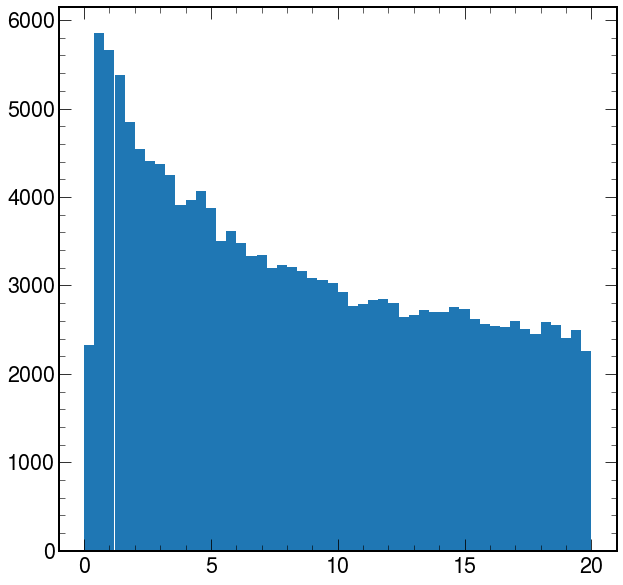

In [9]:
plt.hist(dfb[dfb.is_seed==1].seed_et, bins=50, range=(0,20))

(array([[ 71.,  14.,  33., ...,  40.,   8.,   0.],
        [435., 122., 176., ..., 156., 106., 322.],
        [297., 143., 159., ..., 165., 143., 194.],
        ...,
        [111., 174., 143., ..., 153., 144., 159.],
        [101., 143., 135., ..., 151., 153., 169.],
        [125., 144., 152., ..., 138., 170., 121.]]),
 array([ 0. ,  0.8,  1.6,  2.4,  3.2,  4. ,  4.8,  5.6,  6.4,  7.2,  8. ,
         8.8,  9.6, 10.4, 11.2, 12. , 12.8, 13.6, 14.4, 15.2, 16. , 16.8,
        17.6, 18.4, 19.2, 20. , 20.8, 21.6, 22.4, 23.2, 24. , 24.8, 25.6,
        26.4, 27.2, 28. , 28.8, 29.6, 30.4, 31.2, 32. , 32.8, 33.6, 34.4,
        35.2, 36. , 36.8, 37.6, 38.4, 39.2, 40. ]),
 array([-3. , -2.8, -2.6, -2.4, -2.2, -2. , -1.8, -1.6, -1.4, -1.2, -1. ,
        -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,
         1.4,  1.6,  1.8,  2. ,  2.2,  2.4,  2.6,  2.8,  3. ]),
 <matplotlib.collections.QuadMesh at 0x7f5baf03d9d0>)

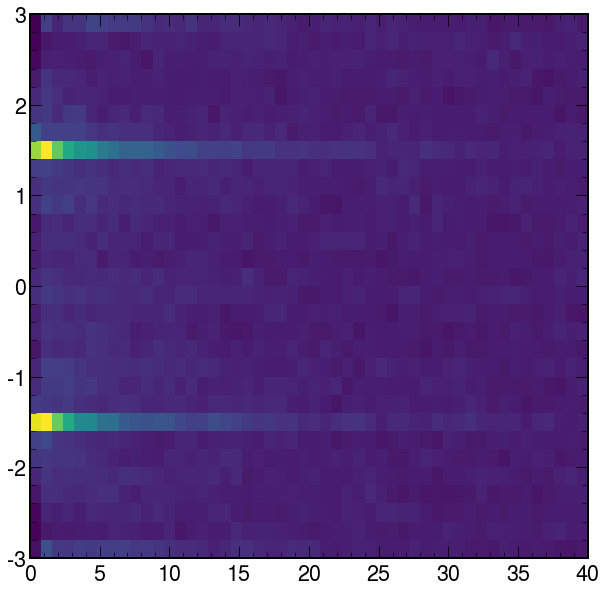

In [10]:
plt.hist2d(dfb[dfb.is_seed==1].seed_et, dfb[dfb.is_seed==1].seed_eta, bins=(50, 30), range=((0,40), (-3,3)))

# Window dimension study

In [11]:
H, phibins , etabins  = np.histogram2d(dfb[dfb.is_seed==0].dphi_seed, dfb[dfb.is_seed==0].deta_seed, 
                          range=((-0.95, 0.95), (-0.4, 0.5)), bins=(51,51))
Hfrac, _ ,_  = np.histogram2d(dfb[dfb.is_seed==0].dphi_seed, dfb[dfb.is_seed==0].deta_seed, 
                              weights=dfb[dfb.is_seed==0].simen_sig, 
                          range=((-0.95, 0.95), (-0.4, 0.5)), bins=(51,51))

X, Y = np.meshgrid(phibins, etabins)

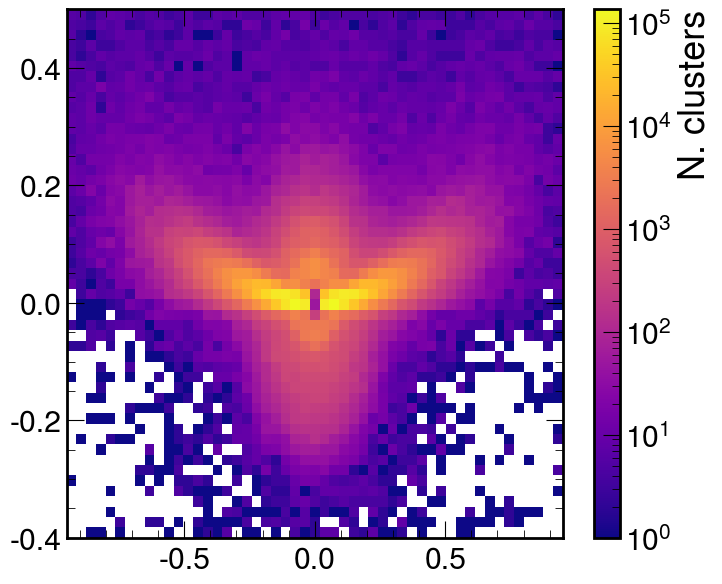

In [13]:
plt.figure(figsize=(8,7), dpi=100)
I = plt.pcolormesh(X, Y, H.T, norm=LogNorm(), cmap="plasma")
plt.colorbar(I, label="N. clusters")

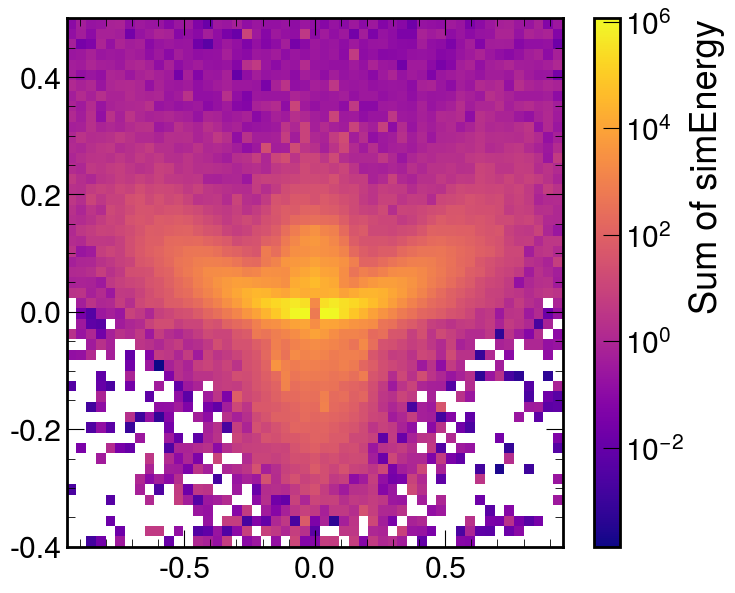

In [14]:
plt.figure(figsize=(8,7), dpi=100)

I = plt.pcolormesh(X, Y, Hfrac.T, norm=LogNorm(), cmap="plasma")
plt.colorbar(label="Sum of simEnergy")

Plotting the normalized distribution of the profiled simEnergy in each bin

/tmp/ipykernel_521/4061902690.py:2: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)


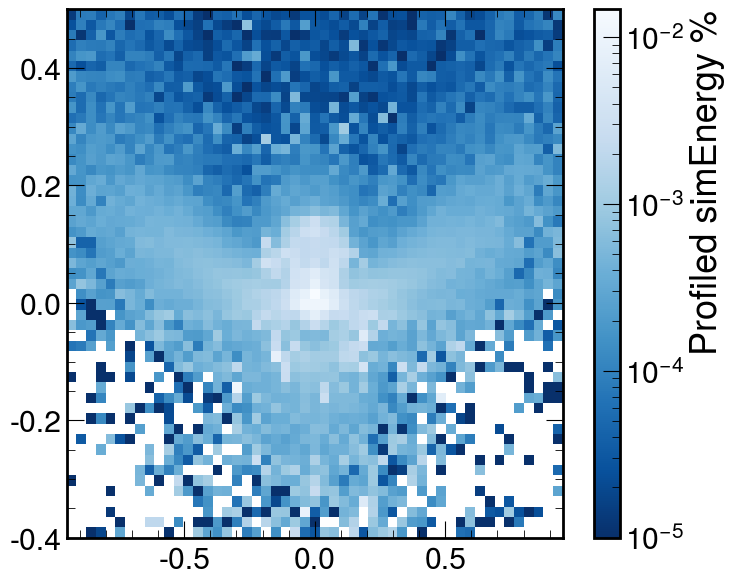

In [15]:
plt.figure(figsize=(8,7), dpi=100)
profile_simen = (Hfrac/H)
np.nan_to_num(profile_simen, copy=False, nan=0.)
prof_simen_perc = profile_simen / np.sum(profile_simen)

I = plt.pcolormesh(X, Y, prof_simen_perc.T, norm=LogNorm(vmin=1e-5), cmap="Blues_r")
plt.colorbar(label="Profiled simEnergy %")

#$plt.gca().set_xticklabels(phibins)

Plotting the normalized distribution of the profiled simEnergy/caloEn in each bin

/tmp/ipykernel_521/2531401568.py:10: RuntimeWarning: invalid value encountered in true_divide
  profile_simen2 = (Hfrac2/H2)


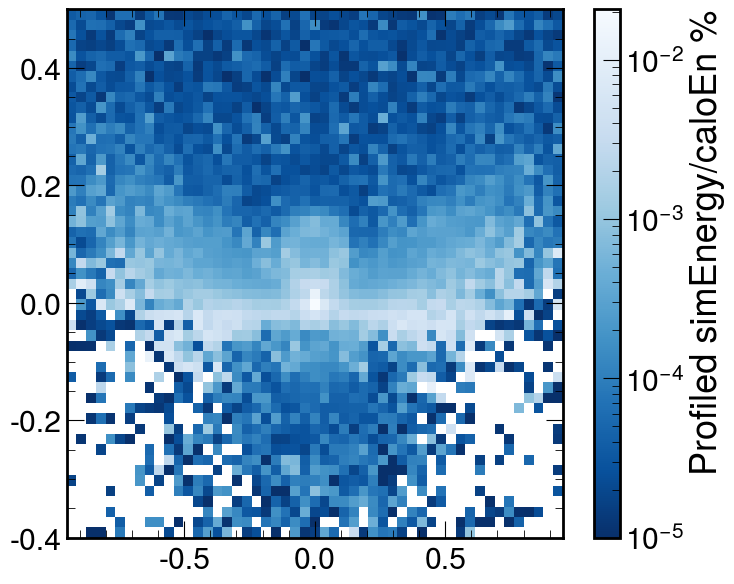

In [16]:
H2, phibins , etabins  = np.histogram2d(dfb[dfb.is_seed==0].dphi_seed, dfb[dfb.is_seed==0].deta_seed, 
                          range=((-0.95, 0.95), (-0.4, 0.5)), bins=(51,51))
Hfrac2, _ ,_  = np.histogram2d(dfb[dfb.is_seed==0].dphi_seed, dfb[dfb.is_seed==0].deta_seed, 
                              weights=dfb[dfb.is_seed==0].simen_sig/dfb[dfb.is_seed==0].calo_simen_good, 
                          range=((-0.95, 0.95), (-0.4, 0.5)), bins=(51,51))

X, Y = np.meshgrid(phibins, etabins)

plt.figure(figsize=(8,7), dpi=100)
profile_simen2 = (Hfrac2/H2)
np.nan_to_num(profile_simen2, copy=False, nan=0.)
prof_simen_perc2 = profile_simen2 / np.sum(profile_simen2)

I = plt.pcolormesh(X, Y, prof_simen_perc2.T, norm=LogNorm(vmin=1e-5), cmap="Blues_r")
plt.colorbar(label="Profiled simEnergy/caloEn %")

#$plt.gca().set_xticklabels(phibins)

### Studying the profile

In [17]:
import numba 
@numba.njit
def get_binrange(X, perc, direction=1):
    S = 0.
    i = 0 if direction>0 else len(X)-1
    while(S<perc):
        S += X[i]
        i += direction
    return i

Text(1, 0, 'ieta, (iphi profiled)')

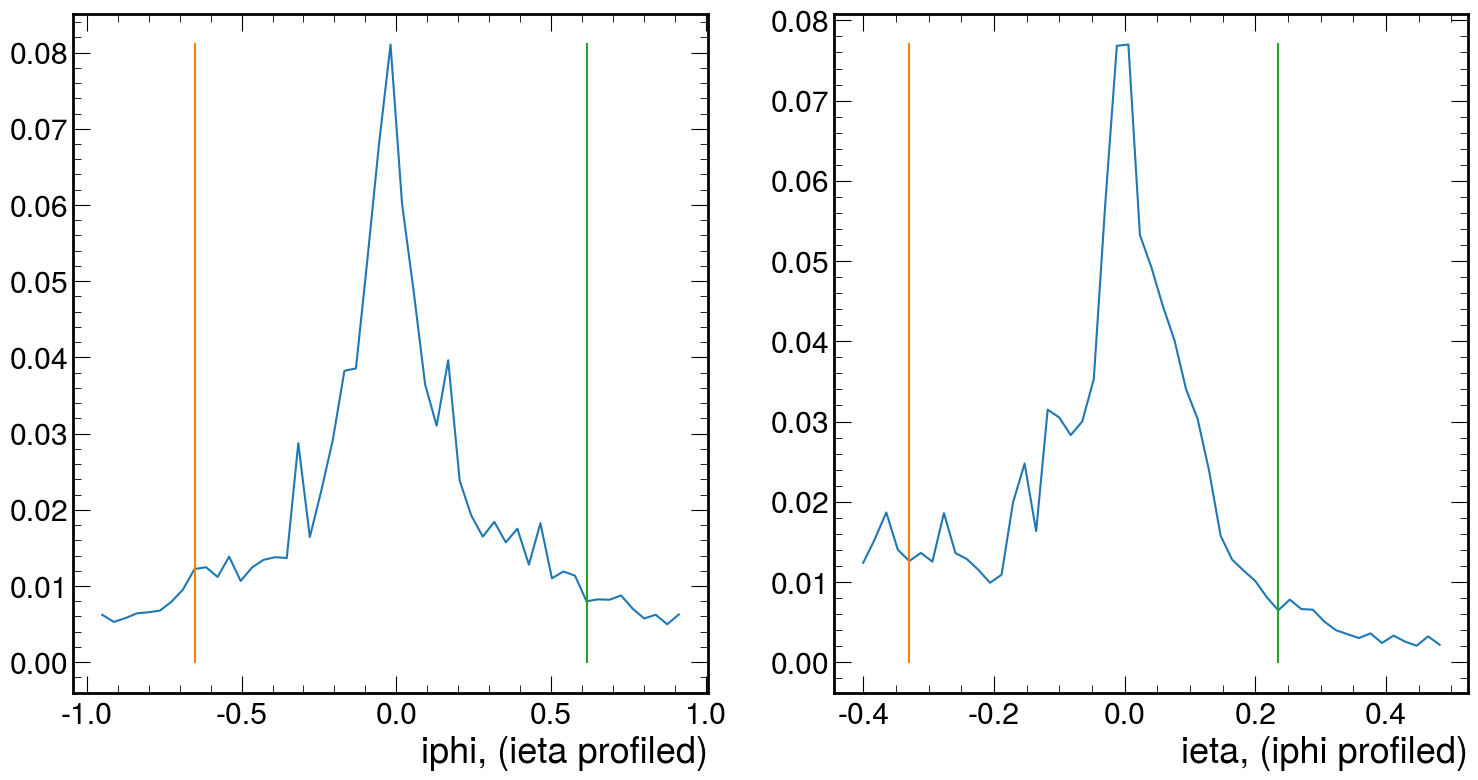

In [18]:
iphi_profile = np.sum(prof_simen_perc, axis=1)
ieta_profile = np.sum(prof_simen_perc.T, axis=1)

prob = 0.05
iphi_min =  get_binrange(iphi_profile,  prob)
iphi_max =  get_binrange(iphi_profile, prob, direction=-1)
ieta_min =  get_binrange(ieta_profile,  prob)
ieta_max =  get_binrange(ieta_profile, prob, direction=-1)

f, (a1, a2) = plt.subplots(1,2, figsize=(18,9), dpi=100)
a1.plot(phibins[:-1], iphi_profile)
a2.plot(etabins[:-1], ieta_profile)
a1.plot([phibins[iphi_min], phibins[iphi_min]], [0,np.max(iphi_profile)])
a1.plot([phibins[iphi_max], phibins[iphi_max]], [0,np.max(iphi_profile)])
a2.plot([etabins[ieta_min], etabins[ieta_min]], [0,np.max(ieta_profile)])
a2.plot([etabins[ieta_max], etabins[ieta_max]], [0,np.max(ieta_profile)])

a1.set_xlabel("iphi, (ieta profiled)")
a2.set_xlabel("ieta, (iphi profiled)")

## Now we do the same in bins of eta

In [19]:
eta_bins_wind = [0.0, 0.2, 0.4, 0.7, 1.0, 1.15, 1.3, 1.4442, 1.566, 1.75, 2.0, 2.4, 3.0]

dfb["eta_bin"] = pd.cut(dfb["seed_eta"].abs(), eta_bins_wind, labels=list(range(len(eta_bins_wind)-1)))

/tmp/ipykernel_521/1576785483.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfb["eta_bin"] = pd.cut(dfb["seed_eta"].abs(), eta_bins_wind, labels=list(range(len(eta_bins_wind)-1)))


### Plotting simEn profiles

/tmp/ipykernel_521/4240029626.py:16: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_521/4240029626.py:16: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_521/4240029626.py:16: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_521/4240029626.py:16: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_521/4240029626.py:16: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_521/4240029626.py:16: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_521/4240029626.py:16: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_521/4240029626.py:16: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_521/42400

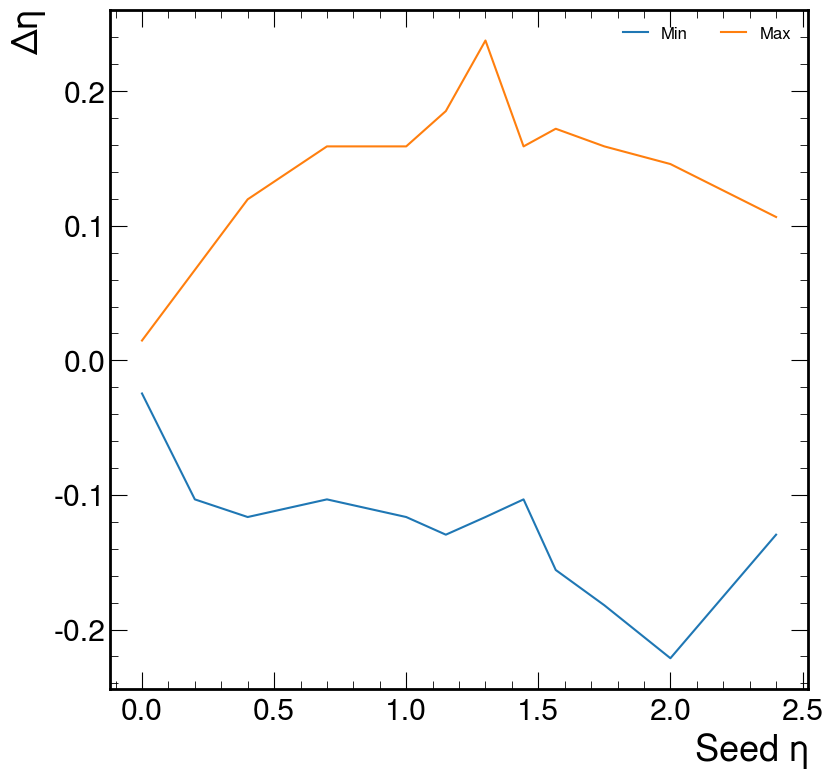

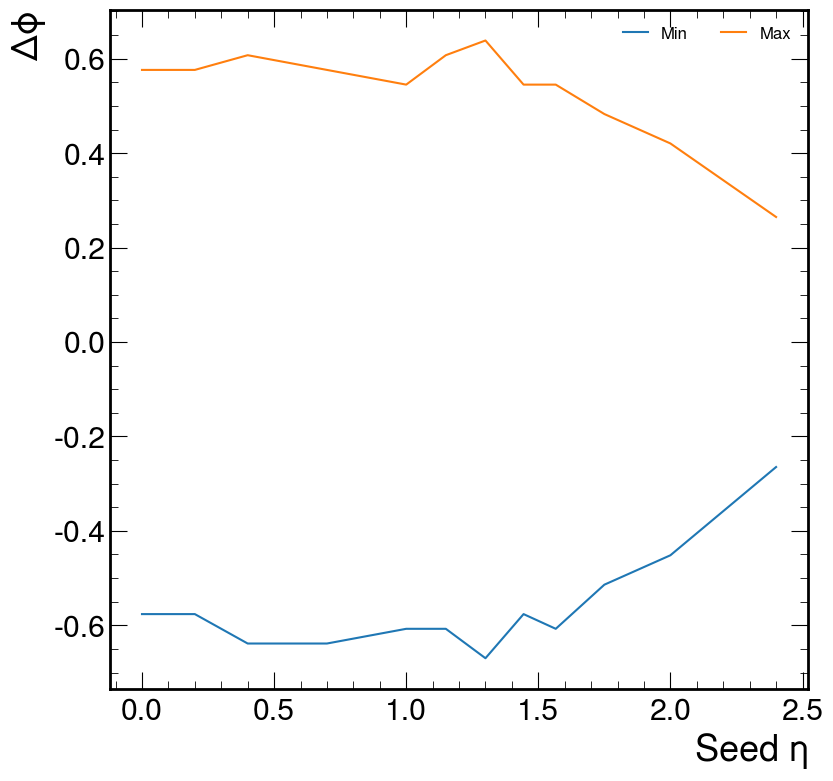

In [20]:
outputdirwind = outputdir + "/windows_simEn"
os.makedirs(outputdirwind, exist_ok=True)

def windows_size_analysis(prob_phi, prob_eta):
    def f(dfs):
        df = dfs[dfs.is_seed ==0]
        H, phibins , etabins  = np.histogram2d(df.dphi_seed, df.deta_seed, 
                              range=((-0.95, 0.95), (-0.3, 0.5)), bins=(61,61))
        Hfrac, _ ,_  = np.histogram2d(df.dphi_seed, df.deta_seed, 
                                  weights=df.simen_sig,  # --> simEN
                              range=((-0.95, 0.95), (-0.3, 0.5)), bins=(61,61))
        
        
        X, Y = np.meshgrid(phibins, etabins)
        
        profile_simen = (Hfrac/H)
        np.nan_to_num(profile_simen, copy=False, nan=0.)
        prof_simen_perc = profile_simen / np.sum(profile_simen)
        
        iphi_profile = np.sum(prof_simen_perc, axis=1)
        ieta_profile = np.sum(prof_simen_perc.T, axis=1)

        iphi_min =  phibins[get_binrange(iphi_profile,  prob_phi)]
        iphi_max =  phibins[get_binrange(iphi_profile, prob_phi, direction=-1)]
        ieta_min =  etabins[get_binrange(ieta_profile,  prob_eta[0])]
        ieta_max =  etabins[get_binrange(ieta_profile, prob_eta[1], direction=-1)]
        
        
        f, (a1, a2) = plt.subplots(1,2, figsize=(18,9), dpi=100)
        a1.plot(phibins[:-1], iphi_profile)
        a2.plot(etabins[:-1], ieta_profile)
        a1.plot([iphi_min,iphi_min], [0,np.max(iphi_profile)])
        a1.plot([iphi_max, iphi_max], [0,np.max(iphi_profile)])
        a2.plot([ieta_min, ieta_min], [0,np.max(ieta_profile)])
        a2.plot([ieta_max, ieta_max], [0,np.max(ieta_profile)])
        a1.set_xlabel("iphi, (ieta profiled)")
        a2.set_xlabel("ieta, (iphi profiled)")
        f.savefig(outputdirwind+f"/simen_profile_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.png")
        f.savefig(outputdirwind+f"/simen_profile_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.pdf")
        plt.close(f)
        
        f, ax  = plt.subplots(1,1, figsize=(10,9), dpi=100)
        I = plt.pcolormesh(X, Y, prof_simen_perc.T, norm=LogNorm(vmin=1e-4), cmap="Blues_r")
        rect = Rectangle((iphi_min, ieta_min), (iphi_max-iphi_min) ,(ieta_max-ieta_min) , 
                                 linewidth=2, edgecolor='orange', facecolor='none')
        ax.add_patch(rect)
        plt.colorbar(I, label="Profiled simEnergy %", ax=ax)
        ax.set_xlabel("$\Delta\phi$")
        ax.set_ylabel("$\Delta\eta$")
        f.savefig(outputdirwind+f"/simen_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.png")
        f.savefig(outputdirwind+f"/simen_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.pdf")
        plt.close(f)
        
        return pd.Series({
            "iphi_min" : iphi_min,
            "iphi_max" : iphi_max,
            "ieta_min" : ieta_min, 
            "ieta_max" : ieta_max, 
        })
    return f


prob_phi = 0.05
prob_eta = [0.05,0.07]
res = dfb.groupby("eta_bin").apply(windows_size_analysis(prob_phi, prob_eta))
res.reset_index(level=0, inplace=True)


# Plotting the limits
f, ax  = plt.subplots(1,1, figsize=(9,9), dpi=100)
ax.plot(eta_bins_wind[:-1], res.ieta_min, label="Min")
ax.plot(eta_bins_wind[:-1], res.ieta_max, label="Max")

ax.legend(ncol=3, fontsize="12")
ax.set_xlabel("Seed $\eta$")
ax.set_ylabel("$\Delta\eta$")
f.savefig(outputdirwind+"/wind_dimension_deta.png")
f.savefig(outputdirwind+"/wind_dimension_deta.pdf")


f, ax  = plt.subplots(1,1, figsize=(9,9), dpi=100)

ax.plot(eta_bins_wind[:-1], res.iphi_min, label="Min")
ax.plot(eta_bins_wind[:-1], res.iphi_max, label="Max")

ax.legend(ncol=3, fontsize="12")
ax.set_xlabel("Seed $\eta$")
ax.set_ylabel("$\Delta\phi$")
f.savefig(outputdirwind+"/wind_dimension_dphi.png")
f.savefig(outputdirwind+"/wind_dimension_dphi.pdf")

#### Plotting by simEn/CaloEn profiled

/tmp/ipykernel_521/3877013058.py:16: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_521/3877013058.py:16: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_521/3877013058.py:16: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_521/3877013058.py:16: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_521/3877013058.py:16: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_521/3877013058.py:16: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_521/3877013058.py:16: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_521/3877013058.py:16: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_521/38770

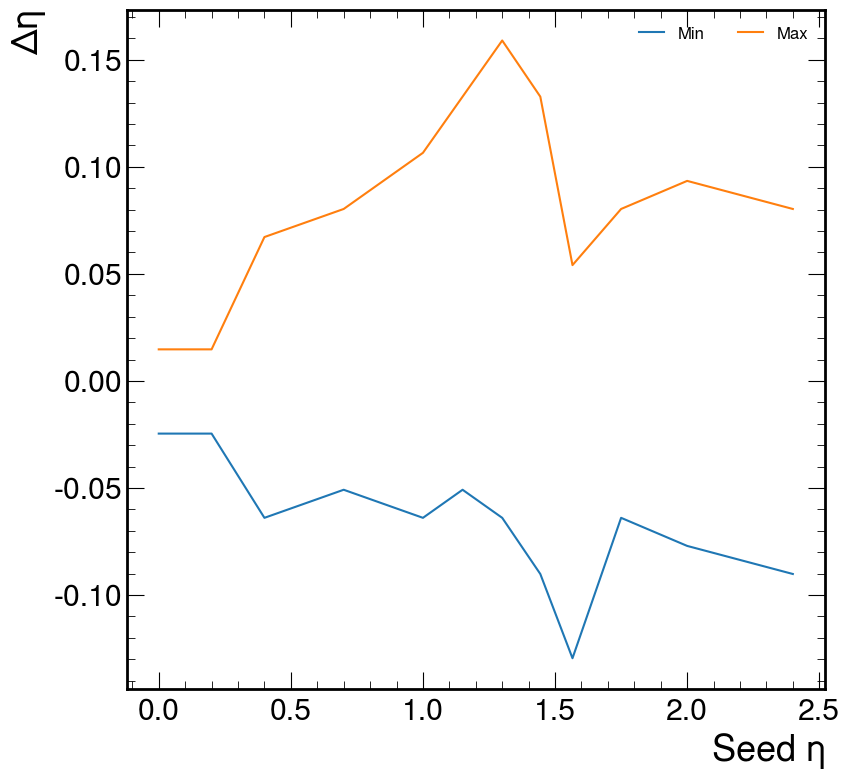

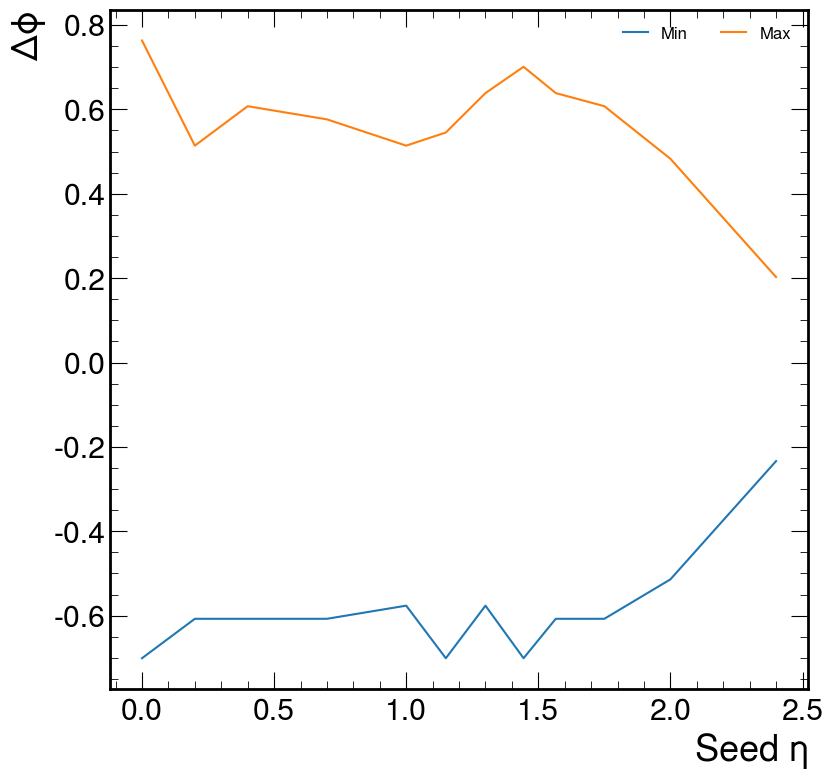

In [21]:
outputdirwind = outputdir + "/windows_simEn_ov_caloEn"
os.makedirs(outputdirwind, exist_ok=True)

def windows_size_analysis(prob_phi, prob_eta):
    def f(dfs):
        df = dfs[dfs.is_seed ==0]
        H, phibins , etabins  = np.histogram2d(df.dphi_seed, df.deta_seed, 
                              range=((-0.95, 0.95), (-0.3, 0.5)), bins=(61,61))
    
        Hfrac, _ ,_  = np.histogram2d(df.dphi_seed, df.deta_seed, 
                                  weights=df.simen_sig/df.calo_simen_good,  # ===> simEn/CaloEN
                              range=((-0.95, 0.95), (-0.3, 0.5)), bins=(61,61))
        
        X, Y = np.meshgrid(phibins, etabins)
        
        profile_simen = (Hfrac/H)
        np.nan_to_num(profile_simen, copy=False, nan=0.)
        prof_simen_perc = profile_simen / np.sum(profile_simen)
        
        iphi_profile = np.sum(prof_simen_perc, axis=1)
        ieta_profile = np.sum(prof_simen_perc.T, axis=1)

        iphi_min =  phibins[get_binrange(iphi_profile,  prob_phi)]
        iphi_max =  phibins[get_binrange(iphi_profile, prob_phi, direction=-1)]
        ieta_min =  etabins[get_binrange(ieta_profile,  prob_eta[0])]
        ieta_max =  etabins[get_binrange(ieta_profile, prob_eta[1], direction=-1)]
        
        
        f, (a1, a2) = plt.subplots(1,2, figsize=(18,9), dpi=100)
        a1.plot(phibins[:-1], iphi_profile)
        a2.plot(etabins[:-1], ieta_profile)
        a1.plot([iphi_min,iphi_min], [0,np.max(iphi_profile)])
        a1.plot([iphi_max, iphi_max], [0,np.max(iphi_profile)])
        a2.plot([ieta_min, ieta_min], [0,np.max(ieta_profile)])
        a2.plot([ieta_max, ieta_max], [0,np.max(ieta_profile)])
        a1.set_xlabel("iphi, (ieta profiled)")
        a2.set_xlabel("ieta, (iphi profiled)")
        f.savefig(outputdirwind+f"/simen_profile_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.png")
        f.savefig(outputdirwind+f"/simen_profile_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.pdf")
        plt.close(f)
        
        f, ax  = plt.subplots(1,1, figsize=(10,9), dpi=100)
        I = plt.pcolormesh(X, Y, prof_simen_perc.T, norm=LogNorm(vmin=1e-4), cmap="Blues_r")
        rect = Rectangle((iphi_min, ieta_min), (iphi_max-iphi_min) ,(ieta_max-ieta_min) , 
                                 linewidth=2, edgecolor='orange', facecolor='none')
        ax.add_patch(rect)
        plt.colorbar(I, label="Profiled simEnergy/CaloEn %", ax=ax)
        ax.set_xlabel("$\Delta\phi$")
        ax.set_ylabel("$\Delta\eta$")
        f.savefig(outputdirwind+f"/simen_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.png")
        f.savefig(outputdirwind+f"/simen_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.pdf")
        plt.close(f)
        
        return pd.Series({
            "iphi_min" : iphi_min,
            "iphi_max" : iphi_max,
            "ieta_min" : ieta_min, 
            "ieta_max" : ieta_max, 
        })
    return f


prob_phi = 0.05
prob_eta = [0.05,0.07]
res = dfb.groupby("eta_bin").apply(windows_size_analysis(prob_phi, prob_eta))
res.reset_index(level=0, inplace=True)


# Plotting the limits
f, ax  = plt.subplots(1,1, figsize=(9,9), dpi=100)
ax.plot(eta_bins_wind[:-1], res.ieta_min, label="Min")
ax.plot(eta_bins_wind[:-1], res.ieta_max, label="Max")

ax.legend(ncol=3, fontsize="12")
ax.set_xlabel("Seed $\eta$")
ax.set_ylabel("$\Delta\eta$")
f.savefig(outputdirwind+"/wind_dimension_deta.png")
f.savefig(outputdirwind+"/wind_dimension_deta.pdf")


f, ax  = plt.subplots(1,1, figsize=(9,9), dpi=100)

ax.plot(eta_bins_wind[:-1], res.iphi_min, label="Min")
ax.plot(eta_bins_wind[:-1], res.iphi_max, label="Max")

ax.legend(ncol=3, fontsize="12")
ax.set_xlabel("Seed $\eta$")
ax.set_ylabel("$\Delta\phi$")
f.savefig(outputdirwind+"/wind_dimension_dphi.png")
f.savefig(outputdirwind+"/wind_dimension_dphi.pdf")

#### Approximate the trend as a linear function

In [22]:
def deta_window(seed_eta):
    EB_max = (0.1/1.5)*seed_eta + 0.1
    EB_min = np.ones_like(seed_eta) * (-0.1)
    EE_max = (0.1/1.5)*(seed_eta-1.5) + 0.2 
    EE_min = -0.1 + (-0.1/1.5)*(seed_eta-1.5)
    out_max = np.where(seed_eta<= 1.5, EB_max, EE_max)
    out_min = np.where(seed_eta<= 1.5, EB_min, EE_min)
    return out_max, out_min

@njit
def dphi_window(seed_eta):
    return 0.7 + (-0.1/3)*seed_eta,  -0.7 + (0.1/3)*seed_eta



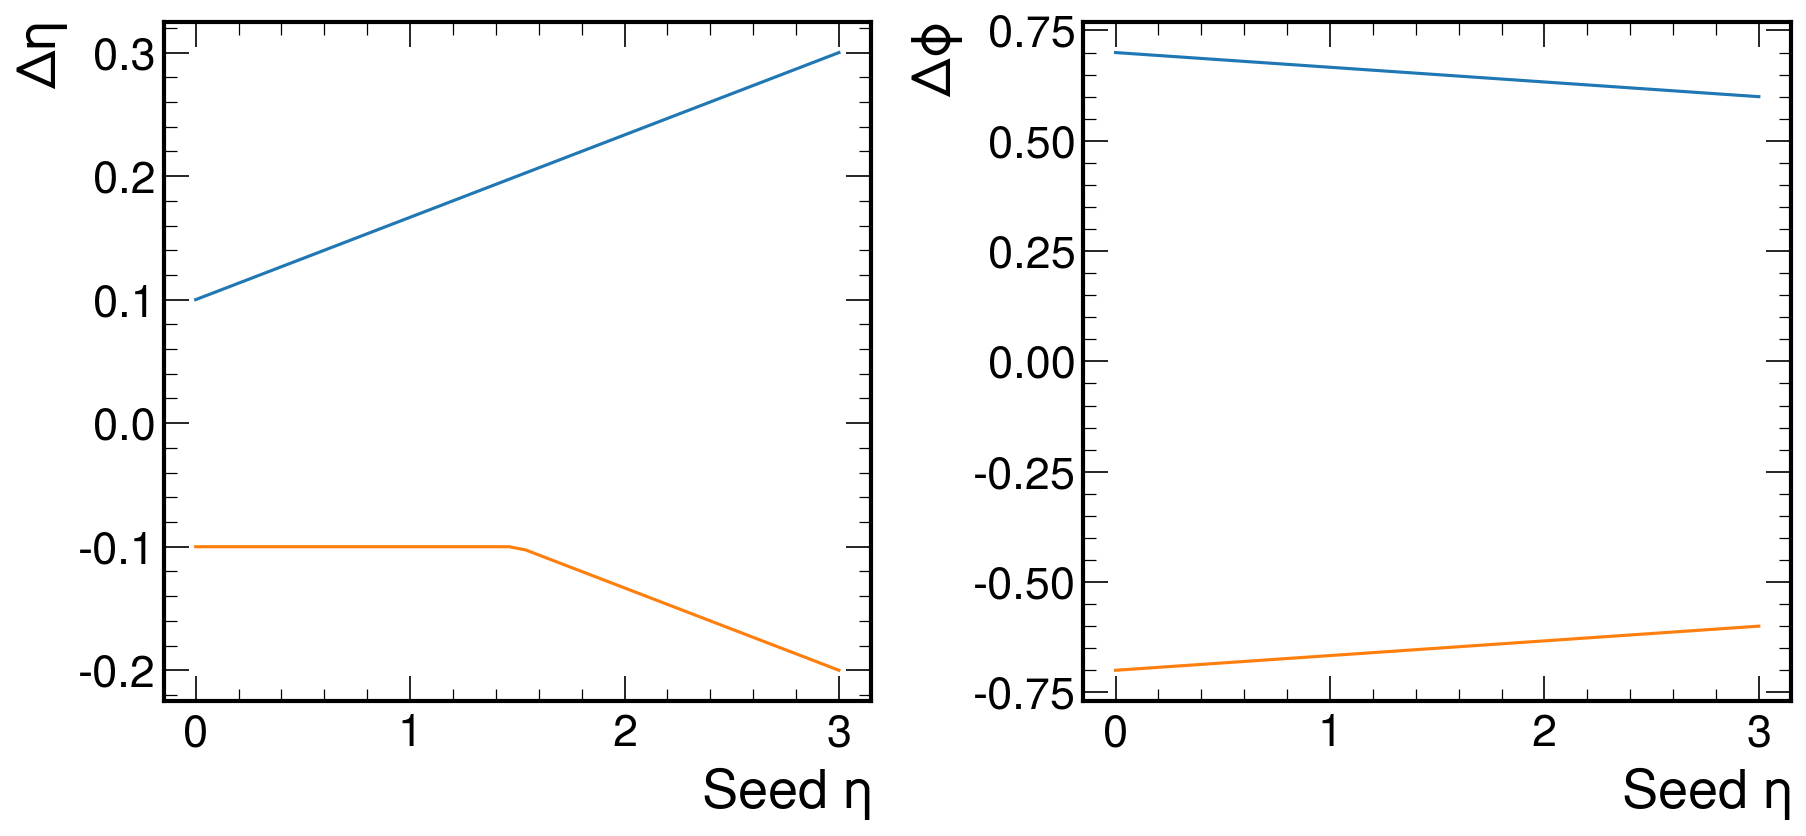

In [23]:
fig,( ax,ay) = plt.subplots(1, 2, figsize=(14, 6), dpi=150)
plt.subplots_adjust(wspace=0.3)
seta = np.linspace(0, 3, 40)
emax, emin = deta_window(seta)
pmax, pmin = dphi_window(seta)
ax.plot(seta, emax)
ax.plot(seta, emin)
ax.set_ylabel("$\Delta\eta$")
ax.set_xlabel("Seed $\eta$")

ay.plot(seta, pmax)
ay.plot(seta, pmin)
ay.set_ylabel("$\Delta\phi$")
ay.set_xlabel("Seed $\eta$")\

outputdirwind = outputdir + "/windows_simEn_ov_caloEn"
fig.savefig(outputdirwind+"/final_window.png")
fig.savefig(outputdirwind+"/final_window.pdf")


outputdirwind = outputdir + "/windows_simEn"
fig.savefig(outputdirwind+"/final_window.png")
fig.savefig(outputdirwind+"/final_window.pdf")

### Plots of the window with the final cut
Doing it both for simEn profile and also for simEn/CaloEn profile

In [24]:
outputdirwind = outputdir + "/windows_simEn"
os.makedirs(outputdirwind, exist_ok=True)

def windows_size_final_plot(dfs):
    df = dfs[dfs.is_seed ==0]
    H, phibins , etabins  = np.histogram2d(df.dphi_seed, df.deta_seed, 
                          range=((-0.95, 0.95), (-0.3, 0.5)), bins=(61,61))
    Hfrac, _ ,_  = np.histogram2d(df.dphi_seed, df.deta_seed, 
                              weights=df.simen_sig,  # --> simEN
                          range=((-0.95, 0.95), (-0.3, 0.5)), bins=(61,61))

    X, Y = np.meshgrid(phibins, etabins)

    profile_simen = (Hfrac/H)
    np.nan_to_num(profile_simen, copy=False, nan=0.)
    prof_simen_perc = profile_simen / np.sum(profile_simen)

    etacenter = (eta_bins_wind[dfs.eta_bin.values[0]] + eta_bins_wind[dfs.eta_bin.values[0]+1])/2
    iphi_max, iphi_min = dphi_window(etacenter)
    ieta_max, ieta_min = deta_window(etacenter)

    # Profiled simEn
    f, ax  = plt.subplots(1,1, figsize=(10,9), dpi=100)
    I = plt.pcolormesh(X, Y, prof_simen_perc.T, norm=LogNorm(vmin=1e-4), cmap="Blues_r")
    rect = Rectangle((iphi_min, ieta_min), (iphi_max-iphi_min) ,(ieta_max-ieta_min) , 
                             linewidth=2, edgecolor='orange', facecolor='none')
    ax.add_patch(rect)
    plt.colorbar(I, label="Profiled simEnergy %", ax=ax)
    ax.set_xlabel("$\Delta\phi$")
    ax.set_ylabel("$\Delta\eta$")
    ax.text(0.001, 1.01, f"eta{eta_bins_wind[dfs.eta_bin.values[0]]}-{eta_bins_wind[dfs.eta_bin.values[0]+1]}", transform=ax.transAxes)
    f.savefig(outputdirwind+f"/simen_FINAL_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.png")
    f.savefig(outputdirwind+f"/simen_FINAL_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.pdf")
    plt.close(f)
    
    # Occupancy
    f, ax  = plt.subplots(1,1, figsize=(10,9), dpi=100)
    I = plt.pcolormesh(X, Y, H.T/np.sum(H), norm=LogNorm(vmin=1e-4), cmap="Blues")
    rect = Rectangle((iphi_min, ieta_min), (iphi_max-iphi_min) ,(ieta_max-ieta_min) , 
                             linewidth=2, edgecolor='orange', facecolor='none')
    ax.add_patch(rect)
    plt.colorbar(I, label="Occupancy", ax=ax)
    ax.set_xlabel("$\Delta\phi$")
    ax.set_ylabel("$\Delta\eta$")
    ax.text(0.001, 1.01, f"eta{eta_bins_wind[dfs.eta_bin.values[0]]}-{eta_bins_wind[dfs.eta_bin.values[0]+1]}", transform=ax.transAxes)
    f.savefig(outputdirwind+f"/simen_FINAL_occupancy_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.png")
    f.savefig(outputdirwind+f"/simen_FINAL_occupancy_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.pdf")
    plt.close(f)
    
    
dfb.groupby("eta_bin").apply(windows_size_final_plot)

/tmp/ipykernel_521/4023003873.py:14: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_521/4023003873.py:14: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_521/4023003873.py:14: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_521/4023003873.py:14: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_521/4023003873.py:14: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_521/4023003873.py:14: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_521/4023003873.py:14: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_521/4023003873.py:14: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_521/40230

Empty DataFrame
Columns: []
Index: []

In [25]:
outputdirwind = outputdir + "/windows_simEn_ov_caloEn"
os.makedirs(outputdirwind, exist_ok=True)

def windows_size_final_plot(dfs):
    df = dfs[dfs.is_seed ==0]
    H, phibins , etabins  = np.histogram2d(df.dphi_seed, df.deta_seed, 
                          range=((-0.95, 0.95), (-0.3, 0.5)), bins=(61,61))
    Hfrac, _ ,_  = np.histogram2d(df.dphi_seed, df.deta_seed, 
                              weights=df.simen_sig/df.calo_simen_good, # --> simEn/CaloEN 
                          range=((-0.95, 0.95), (-0.3, 0.5)), bins=(61,61))

    X, Y = np.meshgrid(phibins, etabins)

    profile_simen = (Hfrac/H)
    np.nan_to_num(profile_simen, copy=False, nan=0.)
    prof_simen_perc = profile_simen / np.sum(profile_simen)

    etacenter = (eta_bins_wind[dfs.eta_bin.values[0]] + eta_bins_wind[dfs.eta_bin.values[0]+1])/2
    iphi_max, iphi_min = dphi_window(etacenter)
    ieta_max, ieta_min = deta_window(etacenter)

    # Profiled simEn
    f, ax  = plt.subplots(1,1, figsize=(10,9), dpi=100)
    I = plt.pcolormesh(X, Y, prof_simen_perc.T, norm=LogNorm(vmin=1e-4), cmap="Blues_r")
    rect = Rectangle((iphi_min, ieta_min), (iphi_max-iphi_min) ,(ieta_max-ieta_min) , 
                             linewidth=2, edgecolor='orange', facecolor='none')
    ax.add_patch(rect)
    plt.colorbar(I, label="Profiled simEnergy/caloEn %", ax=ax)
    ax.set_xlabel("$\Delta\phi$")
    ax.set_ylabel("$\Delta\eta$")
    ax.text(0.001, 1.01, f"eta{eta_bins_wind[dfs.eta_bin.values[0]]}-{eta_bins_wind[dfs.eta_bin.values[0]+1]}", transform=ax.transAxes)
    f.savefig(outputdirwind+f"/simen_FINAL_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.png")
    f.savefig(outputdirwind+f"/simen_FINAL_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.pdf")
    plt.close(f)
    
    # Occupancy
    f, ax  = plt.subplots(1,1, figsize=(10,9), dpi=100)
    I = plt.pcolormesh(X, Y, H.T/np.sum(H), norm=LogNorm(vmin=1e-4), cmap="Blues")
    rect = Rectangle((iphi_min, ieta_min), (iphi_max-iphi_min) ,(ieta_max-ieta_min) , 
                             linewidth=2, edgecolor='orange', facecolor='none')
    ax.add_patch(rect)
    plt.colorbar(I, label="Occupancy", ax=ax)
    ax.set_xlabel("$\Delta\phi$")
    ax.set_ylabel("$\Delta\eta$")
    ax.text(0.001, 1.01, f"eta{eta_bins_wind[dfs.eta_bin.values[0]]}-{eta_bins_wind[dfs.eta_bin.values[0]+1]}", transform=ax.transAxes)
    f.savefig(outputdirwind+f"/simen_FINAL_occupancy_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.png")
    f.savefig(outputdirwind+f"/simen_FINAL_occupancy_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.pdf")
    plt.close(f)
    
    
dfb.groupby("eta_bin").apply(windows_size_final_plot)

/tmp/ipykernel_521/199248077.py:14: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_521/199248077.py:14: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_521/199248077.py:14: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_521/199248077.py:14: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_521/199248077.py:14: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_521/199248077.py:14: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_521/199248077.py:14: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_521/199248077.py:14: RuntimeWarning: invalid value encountered in true_divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_521/199248077.py:

Empty DataFrame
Columns: []
Index: []

# Resolution study

Let's study the best threshold for resolution. 
We have to apply the window definition before studying the best threshold.

Get the "seed", in this case the clusters with the highest score for the caloparticle, 
and collect the clusters around them and **apply** the geometrical window we have defined as a function of the seed eta

In [26]:
eta_max, eta_min = deta_window(dfb.seed_eta.abs().values)
phi_max, phi_min = dphi_window(dfb.seed_eta.abs().values)

dfb["in_window_new"] =  (dfb.deta_seed >= eta_min) & (dfb.deta_seed <= eta_max ) & \
                        (dfb.dphi_seed >= phi_min) & (dfb.dphi_seed <= phi_max)    

/tmp/ipykernel_521/3615905916.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfb["in_window_new"] =  (dfb.deta_seed >= eta_min) & (dfb.deta_seed <= eta_max ) & \


Analyzing the truth level resolution for clusters in the geometrical window

In [27]:
def bin_analysis(group):
    ratio_left = group["EoEtrue"].quantile(0.16)
    ratio_right = group["EoEtrue"].quantile(0.84)
    ratio_mean = group[(group.EoEtrue >= ratio_left) & (group.EoEtrue <= ratio_right) ].EoEtrue.mean()
    count = group["EoEtrue"].count()
    return pd.Series(  
        { 
             "quantile_down": ratio_left,
             "quantile_up": ratio_right,
             "EoEtrue_68scale": ratio_mean,
             "EoEtrue_68width": (ratio_right-ratio_left)/2, 
             #"EoEtrue_68width": abs(ratio_right- ratio_left), 
             "EoEtrue_scale":  group.EoEtrue.mean(),
             "EoEtrue_rms":  group.EoEtrue.std(),
             "rel_err" : 1/np.sqrt(count)
        })


In [6]:
etas = [0.0, 0.2, 0.4, 0.7, 1.0, 1.15, 1.3, 1.4442, 1.566, 1.75, 2.0,2.4,3.0]
ets = [ 1,3,6,10] + list(range(20, 200, 20)) + list(range(240, 500, 40)) + [500]

In [59]:
thres = np.logspace(-4,-0.7, 60)
    
res= []
# res_all = []

#Taking all the cluster passing the simfraction threshold, or beeing the seed
for i, thr in enumerate(thres):
    print(f"{i}) SimFracr threshold: {thr}")
    
    # we select only the clusters **inside the window** and passing the threshold or being the seed.
    g = dfb[ (dfb.in_window_new) & ((dfb.simfrac_sig >  thr) | (dfb.is_seed==1))]\
            .groupby("window_index", sort=False).agg(
                        {
                         "en": 'sum' ,
                         "calo_simen_good": "first", 
                         "seed_et": "first",
                         "seed_eta": "first"
                            })
    g["EoEtrue"] = g["en"] / g["calo_simen_good"]
    g["thr"]= thr
    g["et_bin"] = pd.cut(g["seed_et"], ets, labels=list(range(len(ets)-1)))
    g["eta_bin"] = pd.cut(g["seed_eta"].abs(), etas, labels=list(range(len(etas)-1)))

    scanres = g.groupby(["et_bin","eta_bin"]).apply(bin_analysis)
    #scanres = applyParallel(g.groupby(["et_bin","eta_bin"]), bin_analysis)
    scanres["thr"] = thr
    res.append(scanres)

res = pd.concat(res)
res.reset_index(level=0, inplace=True)
res.reset_index(level=0, inplace=True)

0) SimFracr threshold: 0.0001
1) SimFracr threshold: 0.00011374497075739473
2) SimFracr threshold: 0.0001293791837260057
3) SimFracr threshold: 0.0001471623146953012
4) SimFracr threshold: 0.00016738973181607556
5) SimFracr threshold: 0.0001903974015050766
6) SimFracr threshold: 0.00021656746866478862
7) SimFracr threshold: 0.00024633460390279384
8) SimFracr threshold: 0.000280193223174577
9) SimFracr threshold: 0.0003187056997641244
10) SimFracr threshold: 0.00036251170499885317
11) SimFracr threshold: 0.0004123388328430786
12) SimFracr threshold: 0.00046901468483874254
13) SimFracr threshold: 0.0005334806161177142
14) SimFracr threshold: 0.0006068073707994633
15) SimFracr threshold: 0.0006902128664695653
16) SimFracr threshold: 0.0007850824231295831
17) SimFracr threshold: 0.0008929917726101903
18) SimFracr threshold: 0.0010157332306214009
19) SimFracr threshold: 0.0011553454661434532
20) SimFracr threshold: 0.0013141473626117554
21) SimFracr threshold: 0.0014947765333118152
22) SimF

In [61]:
res

eta_bin et_bin  quantile_down  quantile_up  EoEtrue_68scale  \
0           0      0       0.462188     0.792140         0.642634   
1           1      0       0.552513     0.791624         0.677811   
2           2      0       0.540317     0.782948         0.677902   
3           3      0       0.532128     0.784986         0.666154   
4           4      0       0.519462     0.760260         0.645347   
...       ...    ...            ...          ...              ...   
14395       7     19       1.011756     1.042747         1.025429   
14396       8     19       1.010962     1.037533         1.023487   
14397       9     19       1.012062     1.035146         1.023573   
14398      10     19       1.011390     1.037259         1.024249   
14399      11     19       1.017571     1.073714         1.043400   

       EoEtrue_68width  EoEtrue_scale  EoEtrue_rms   rel_err       thr  
0             0.164976       0.791951     2.676899  0.028072  0.000100  
1             0.119556       0.675507     0.140642  0.031607  0.000100  
2             0.121316       0.669480     0.142691  0.024147  0.000100  
3             0.126429       0.667361     0.145976  0.021522  0.000100  
4             0.120399       0.647813     0.131819  0.030875  0.000100  
...                ...            ...          ...       ...       ...  
14395         0.015495       1.042750     0.106893  0.058421  0.199526  
14396         0.013285       1.042698     0.131608  0.023709  0.199526  
14397         0.011542       1.023554     0.011631  0.020008  0.199526  
14398         0.012934       1.024672     0.013473  0.014094  0.199526  
14399         0.028071       1.045924     0.030513  0.014482  0.199526  

[14400 rows x 10 columns]

In [62]:
res.to_csv(outputdir + "/resolution_analysis_allthresholds.csv", sep=";", index=False)

## By Et and eta bin

Now plotting all the resolution

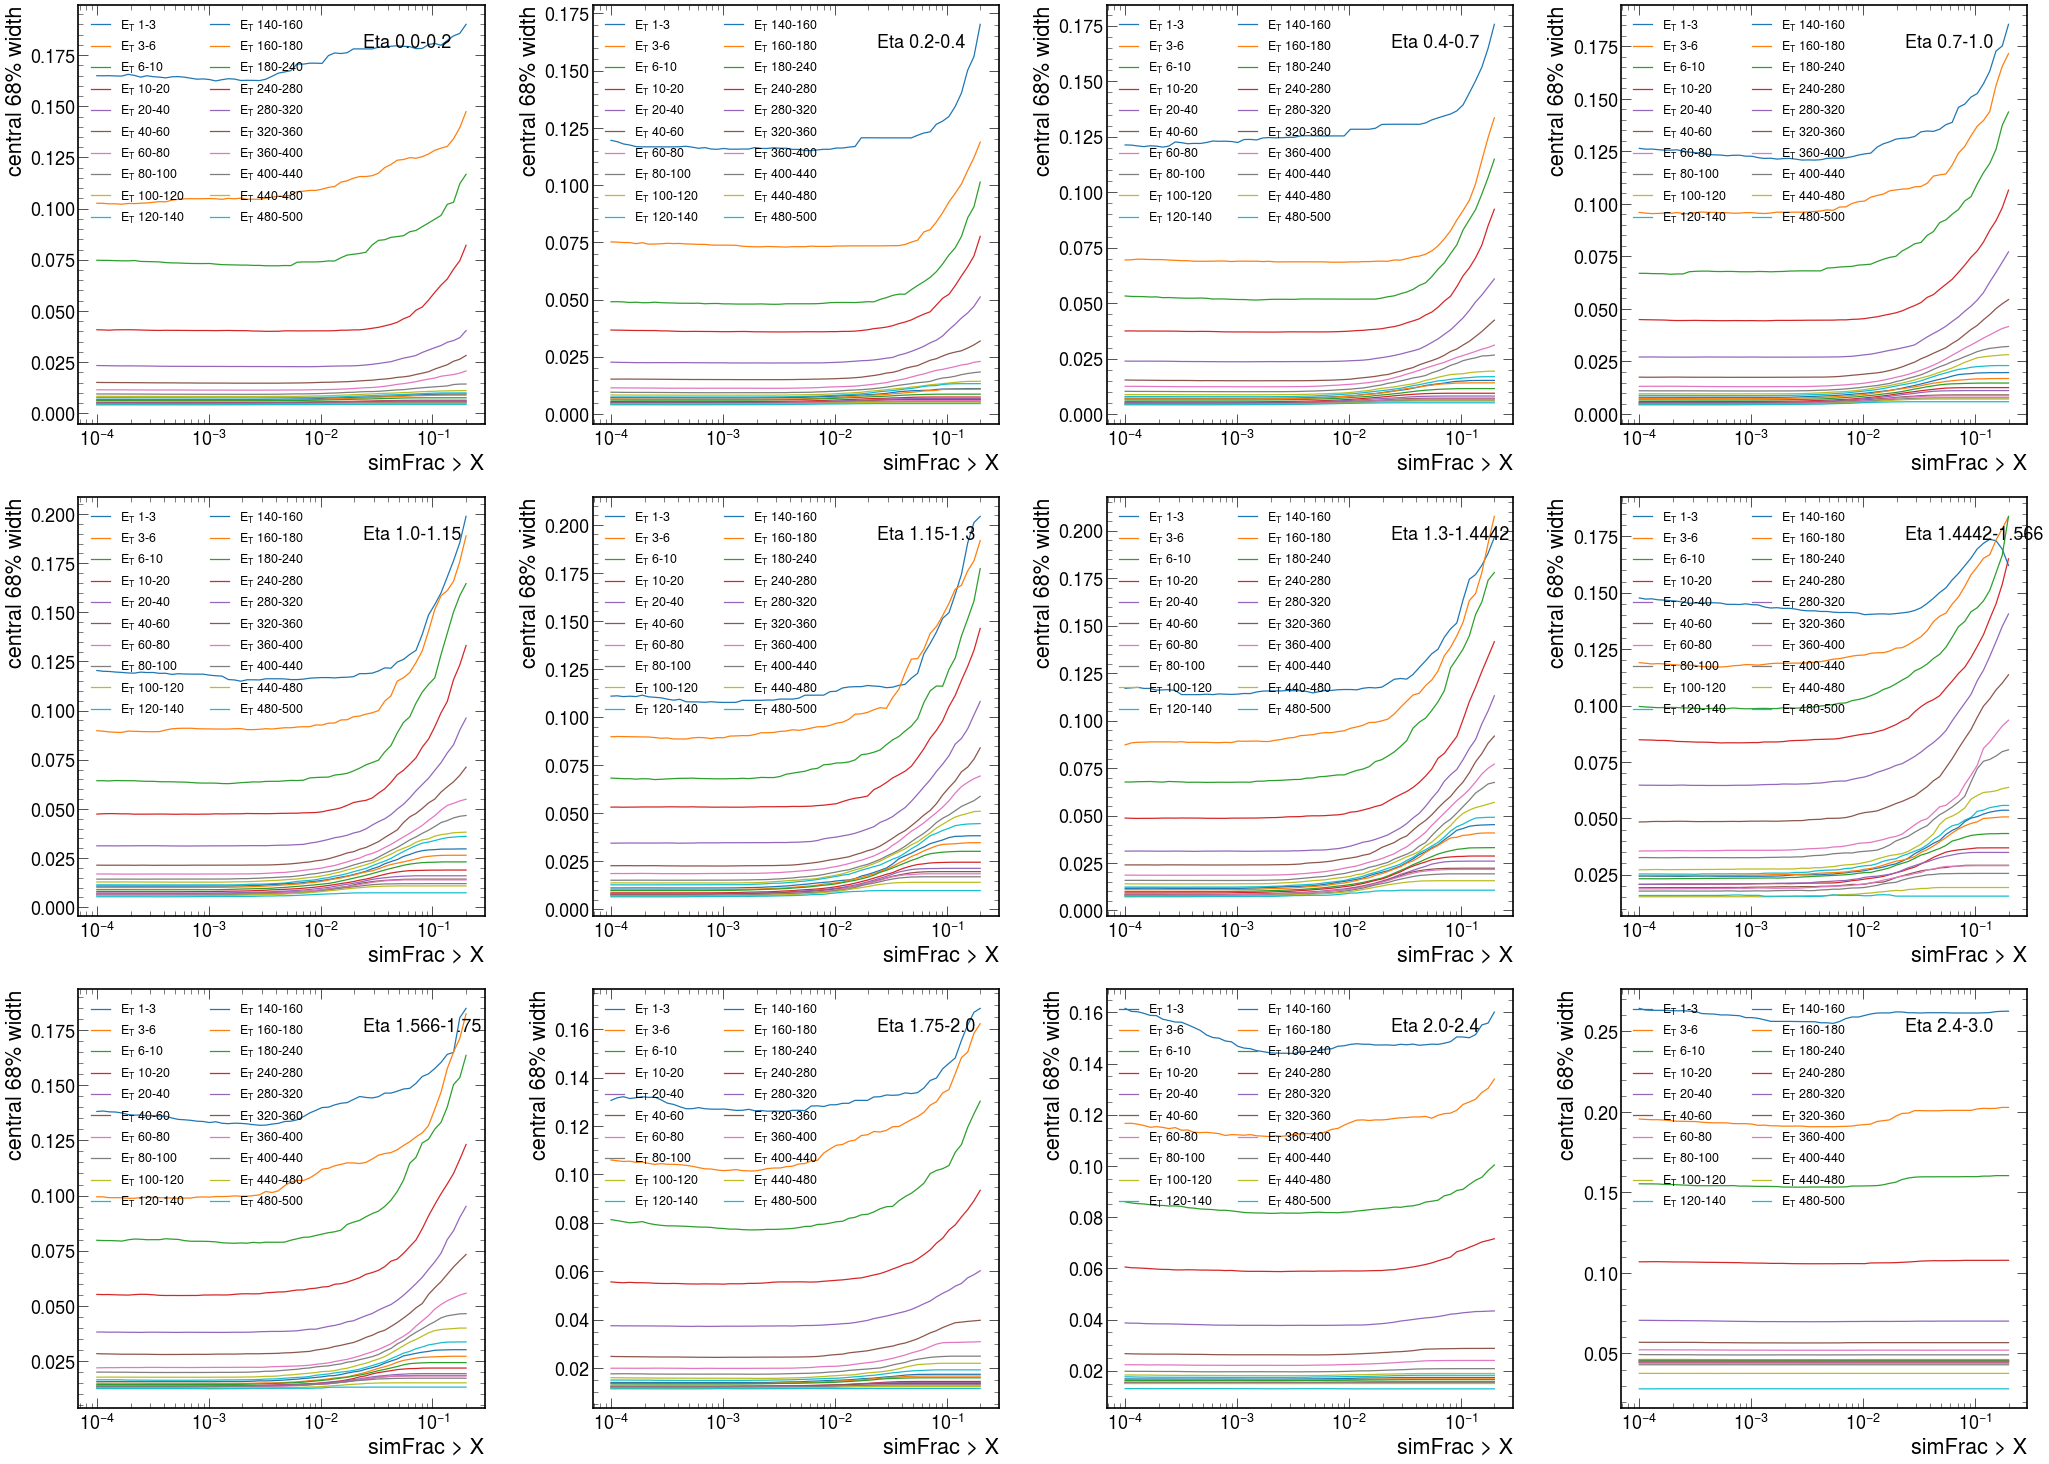

In [63]:
f, axs = plt.subplots(3,4, figsize=(35,25), dpi=60)

for i in range(len(etas)-1):   
    ax = axs[i//4][i% 4]
    for y in range(len(ets)-1):
        a = res[(res.eta_bin == i) & (res.et_bin==y)]
        ax.plot(a.thr, a.EoEtrue_68width, label='$E_T$ {}-{}'.format(ets[y], ets[y+1]))
        
    ax.text(0.7,0.9, "Eta {}-{}".format(etas[i],etas[i+1]),fontsize="small", transform=ax.transAxes)
    ax.legend(fontsize="xx-small", loc='upper left', ncol=2)
    ax.set_ylabel("central 68% width")
    ax.set_xlabel("simFrac > X")
#     ax.set_xlim(0.01, 1000)
    ax.set_xscale("log")

f.tight_layout()
f.savefig(outputdir+'/Width_all.png')
f.savefig(outputdir+'/Width_all.pdf')

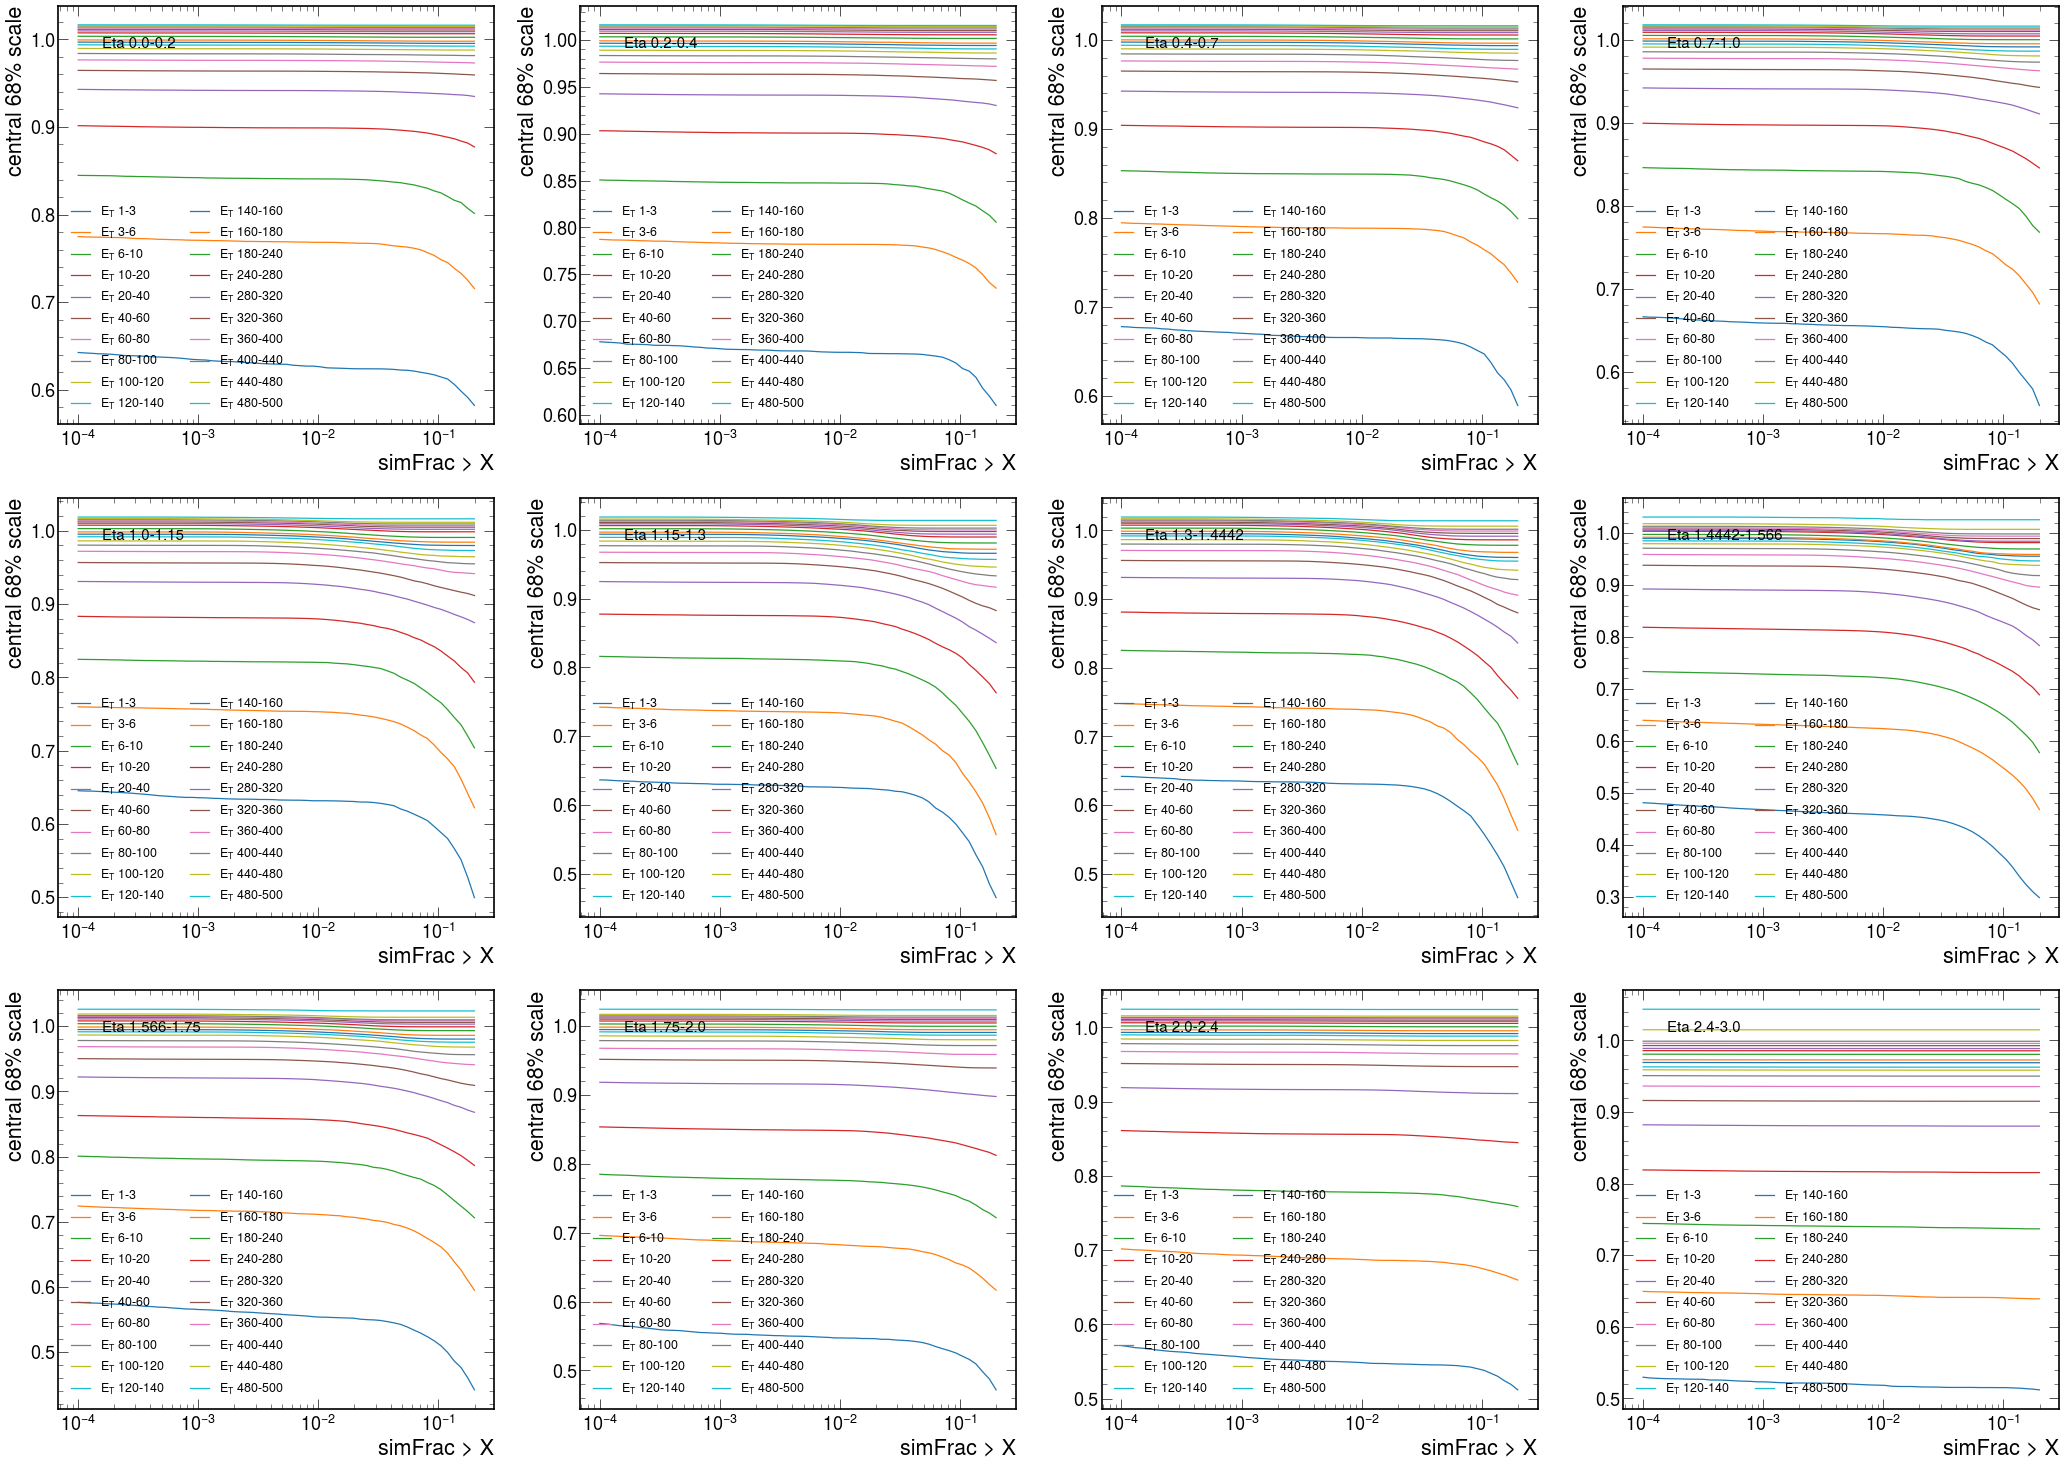

In [64]:
f, axs = plt.subplots(3,4, figsize=(35,25), dpi=60)

for i in range(len(etas)-1):   
    ax = axs[i//4][i% 4]
    for y in range(len(ets)-1):
        a = res[(res.eta_bin == i) & (res.et_bin==y)]
        ax.plot(a.thr, a.EoEtrue_68scale, label='$E_T$ {}-{}'.format(ets[y], ets[y+1]))
        
    ax.text(0.1,0.9, "Eta {}-{}".format(etas[i],etas[i+1]),fontsize="x-small", transform=ax.transAxes)
    ax.legend(fontsize="xx-small", loc='lower left', ncol=2)
    ax.set_ylabel("central 68% scale")
    ax.set_xlabel("simFrac > X")
#     ax.set_xlim(0.001, 0.05)
    ax.set_xscale("log")

f.tight_layout()
f.savefig(outputdir+'/Scale_all.png')

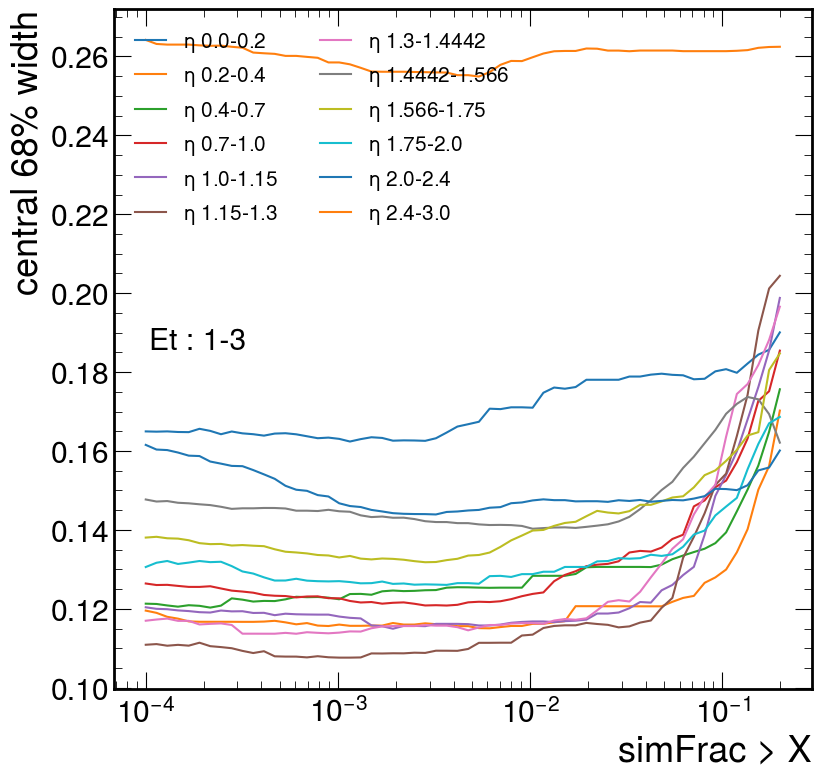

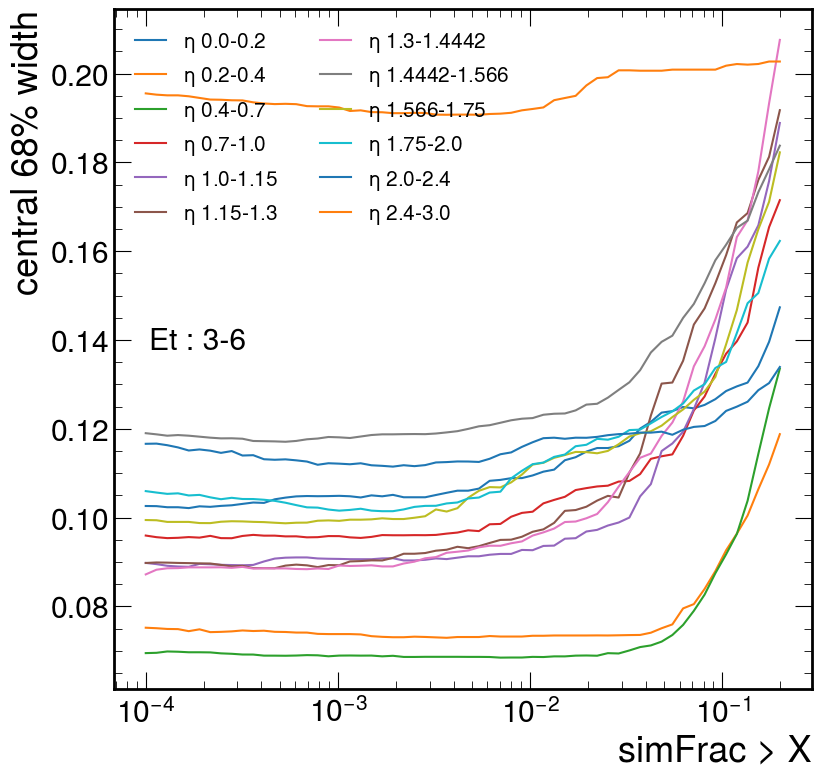

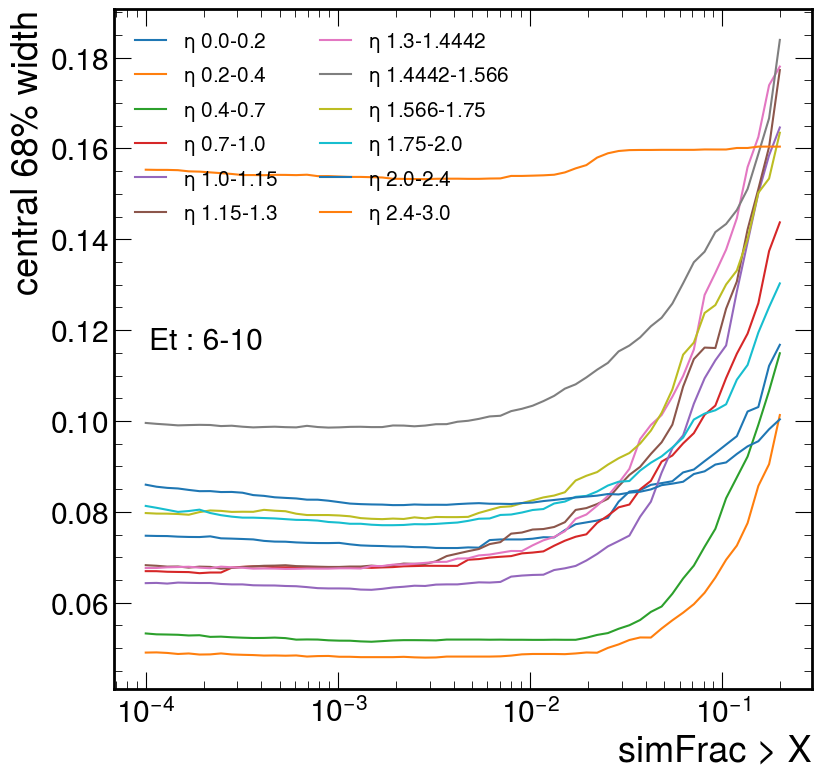

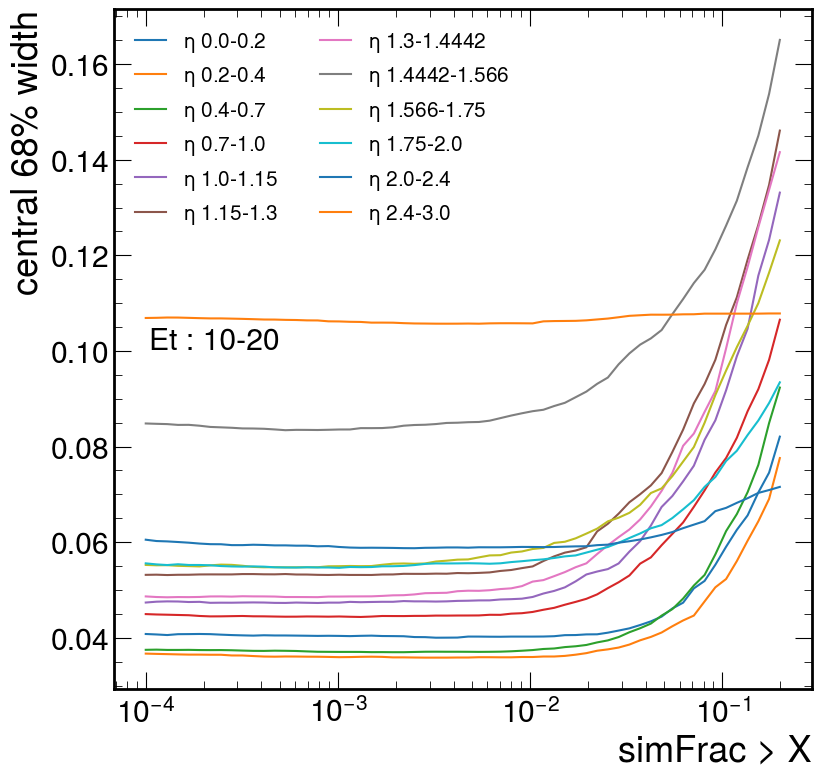

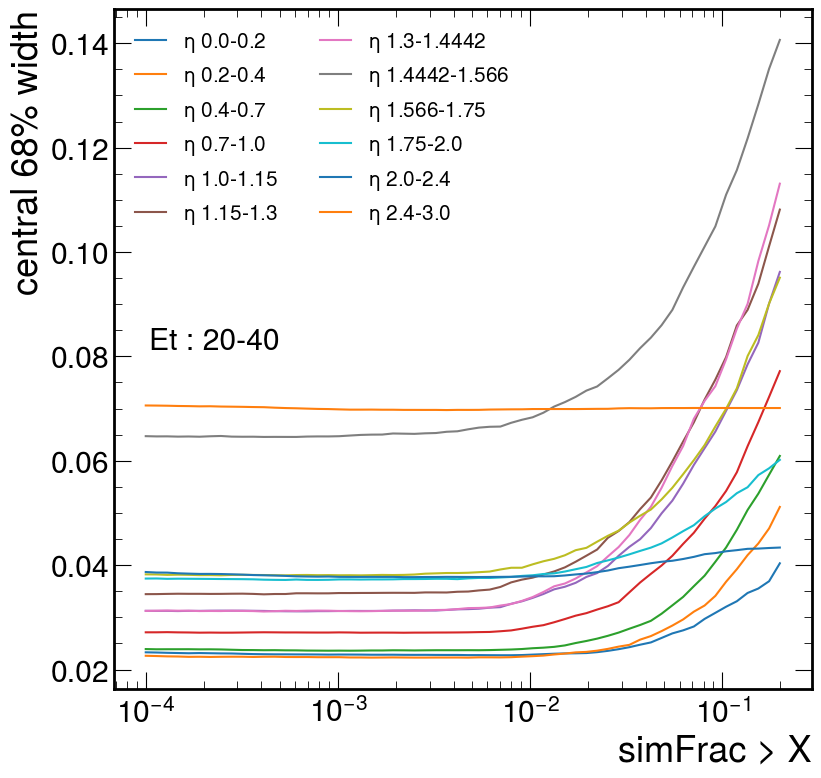

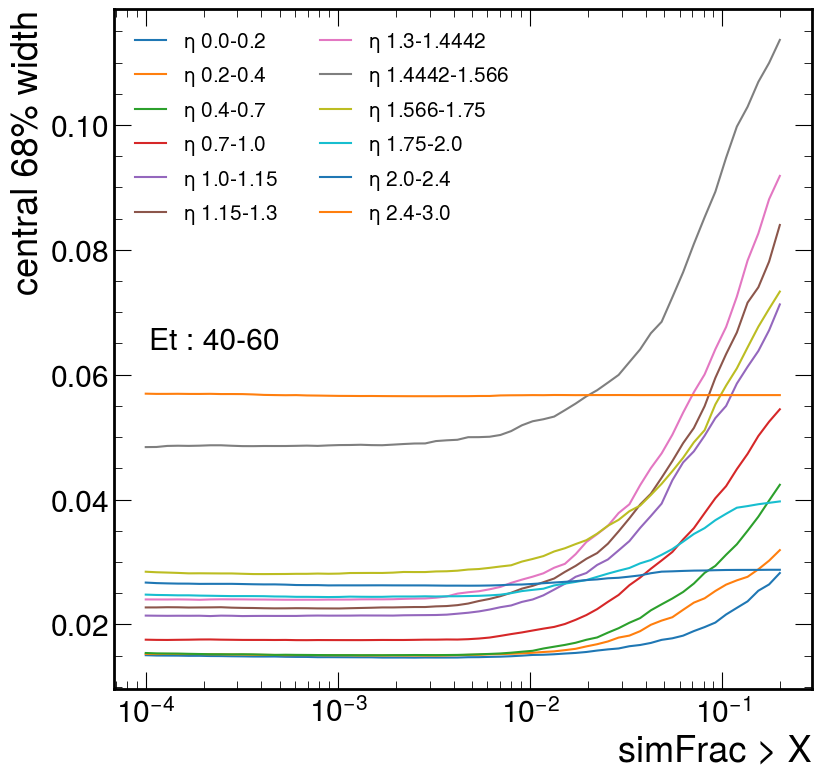

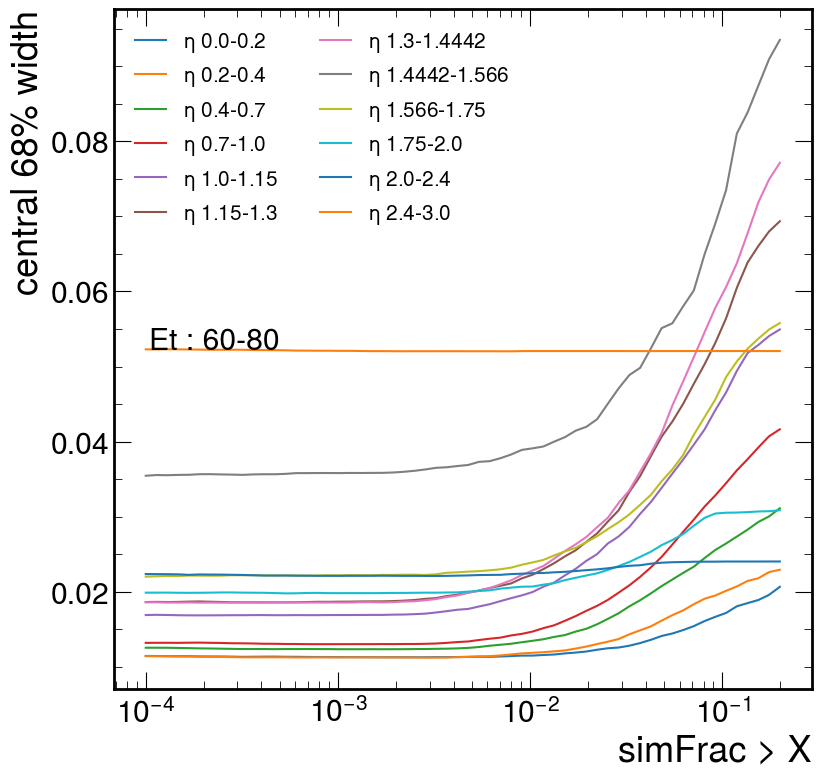

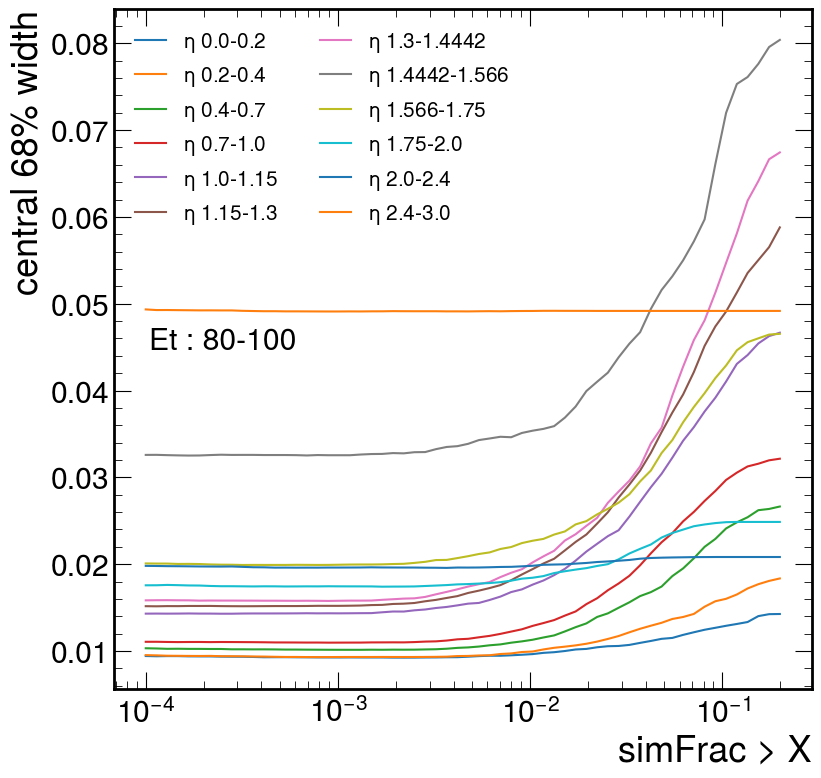

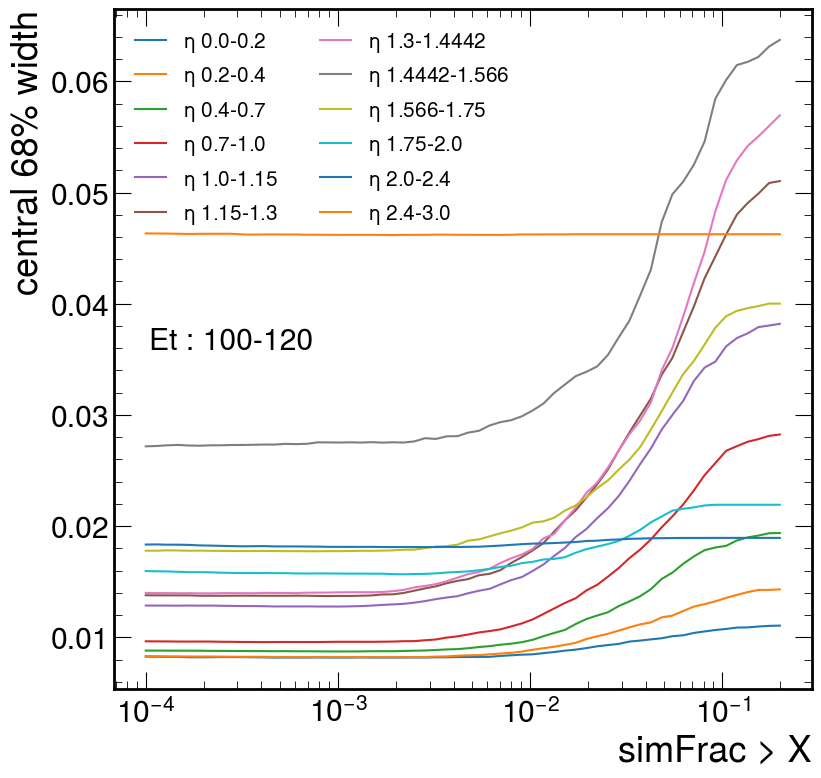

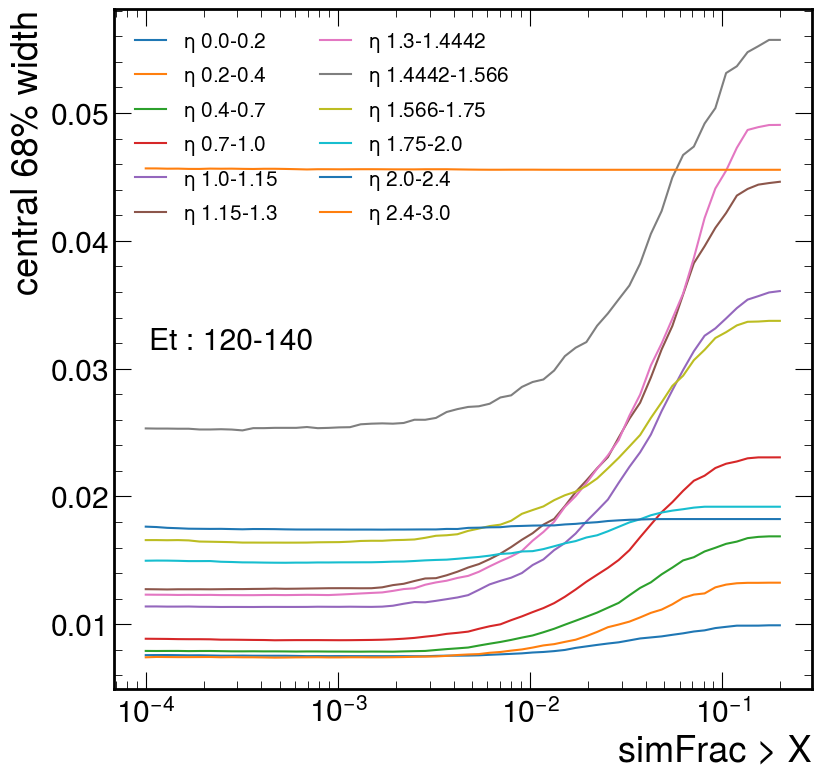

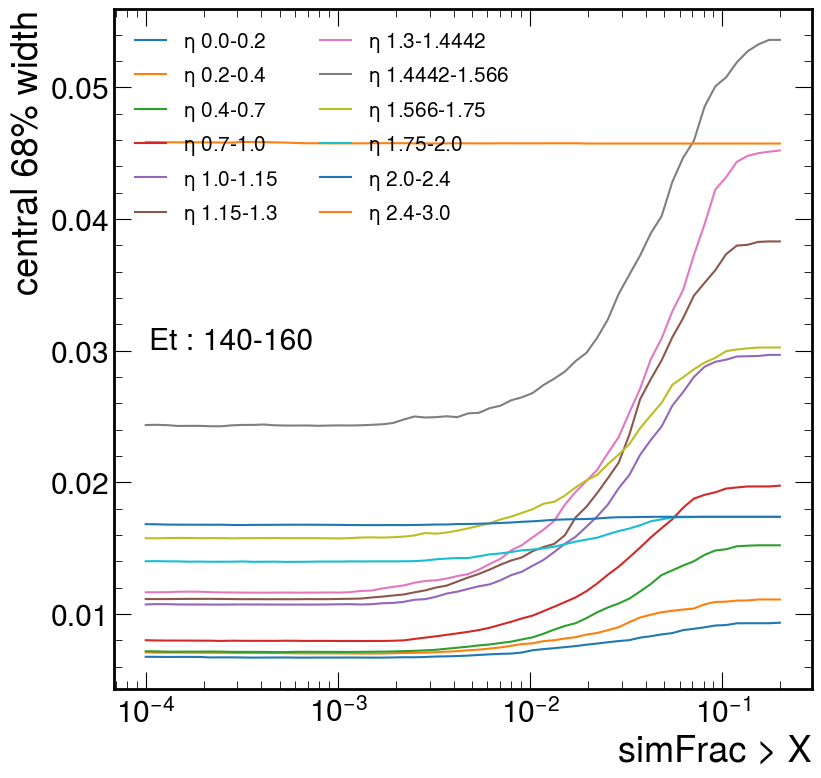

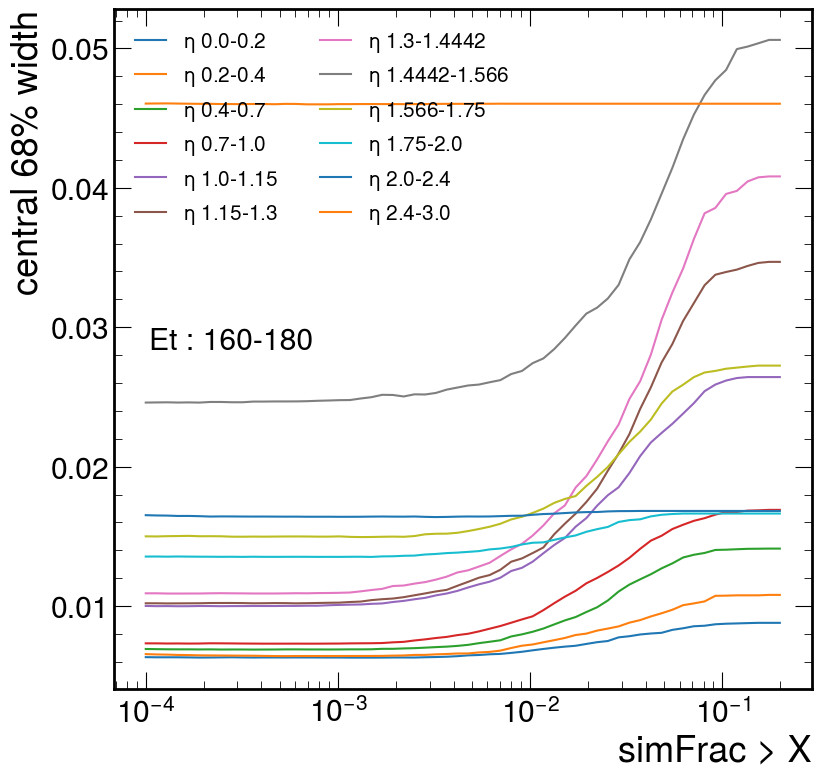

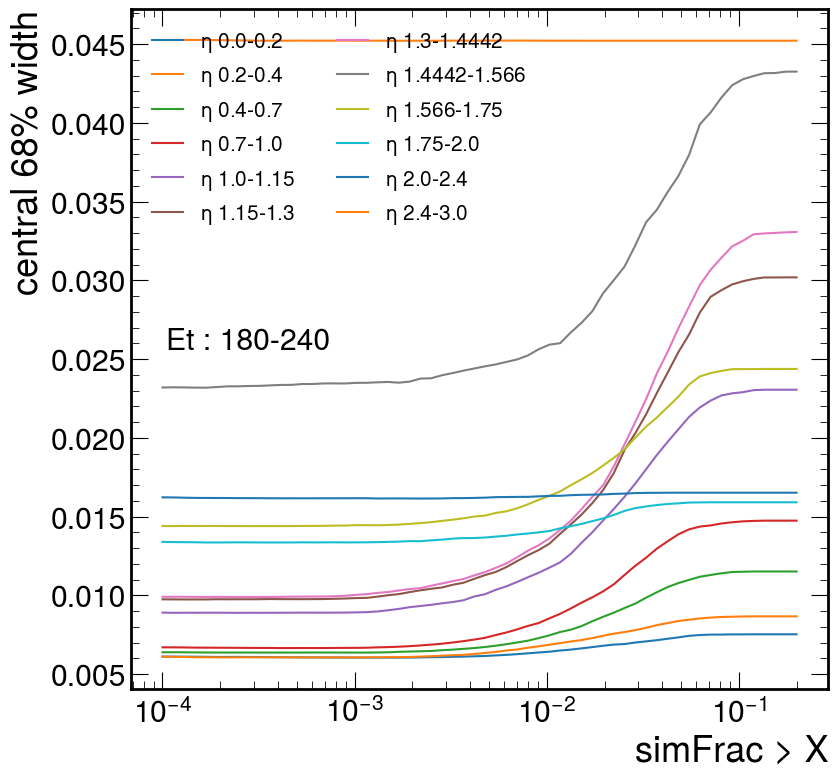

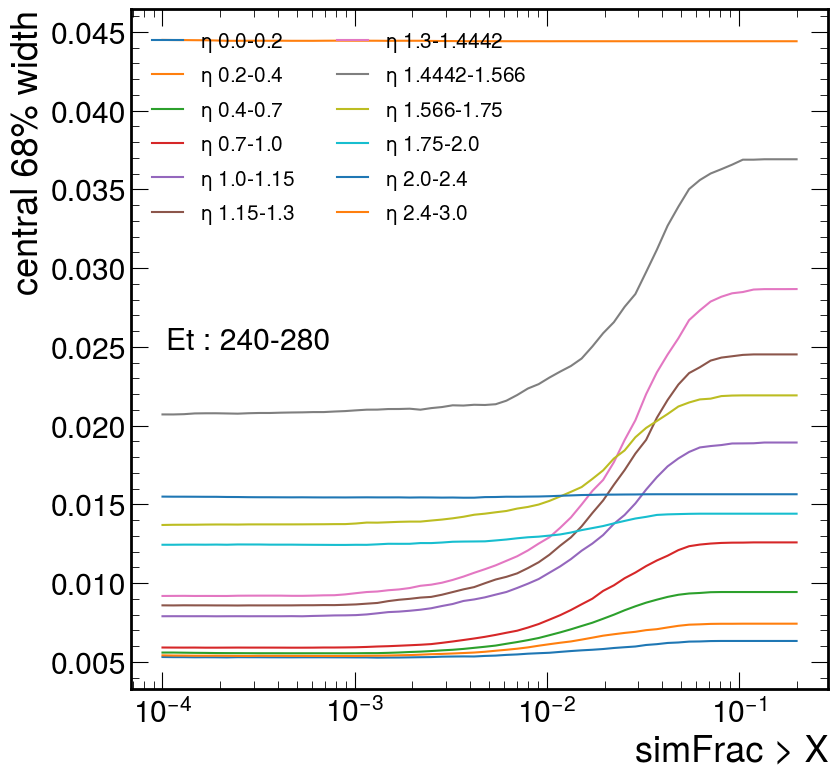

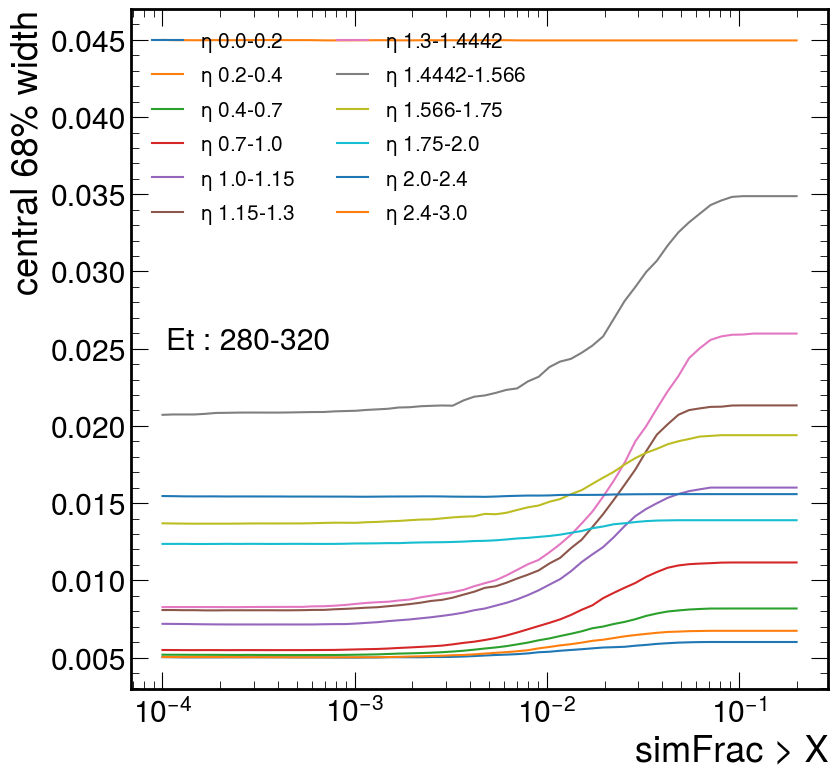

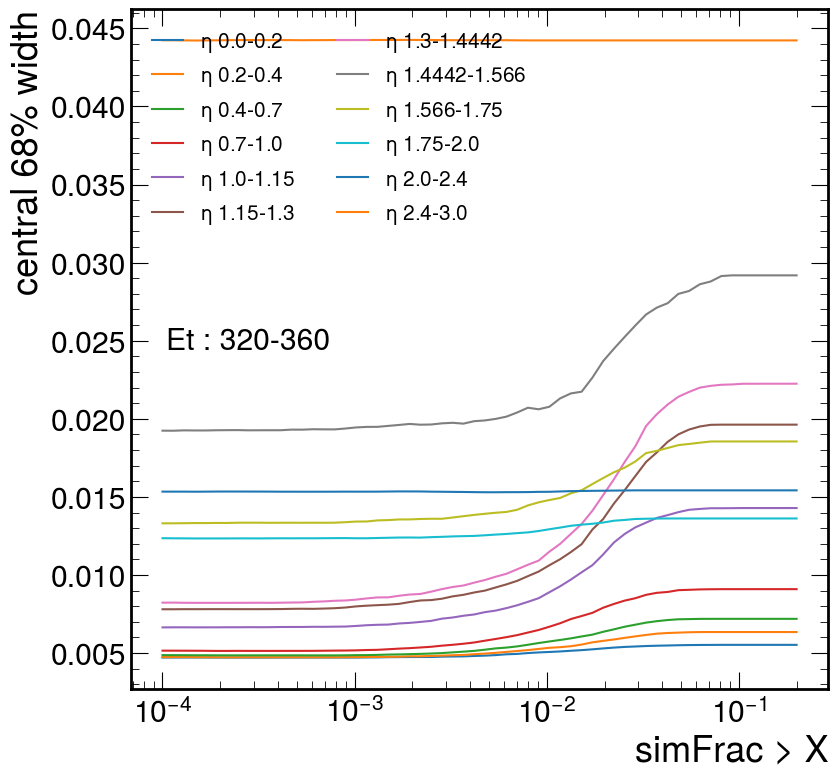

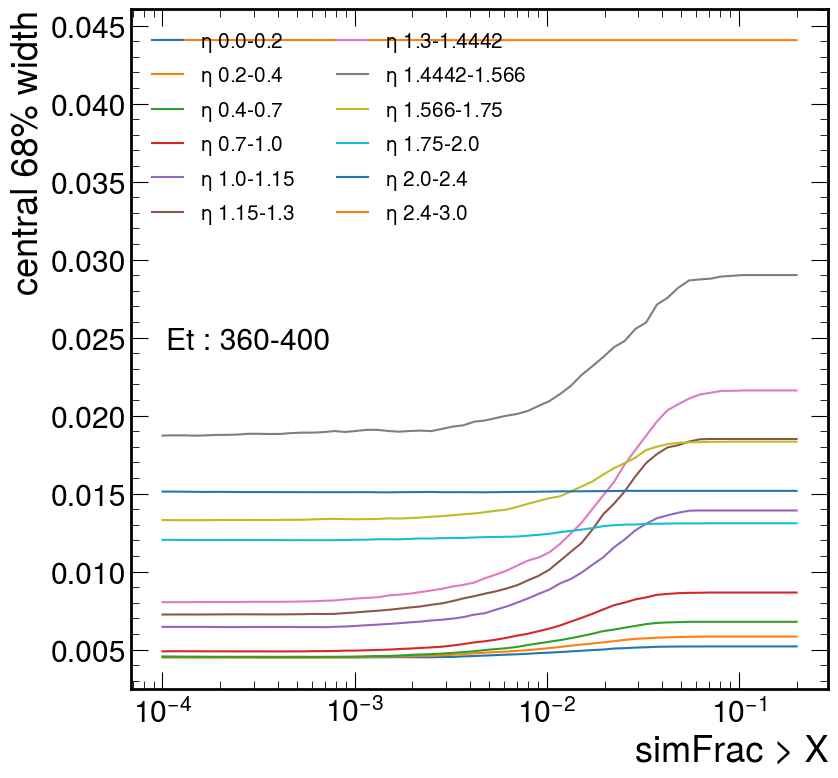

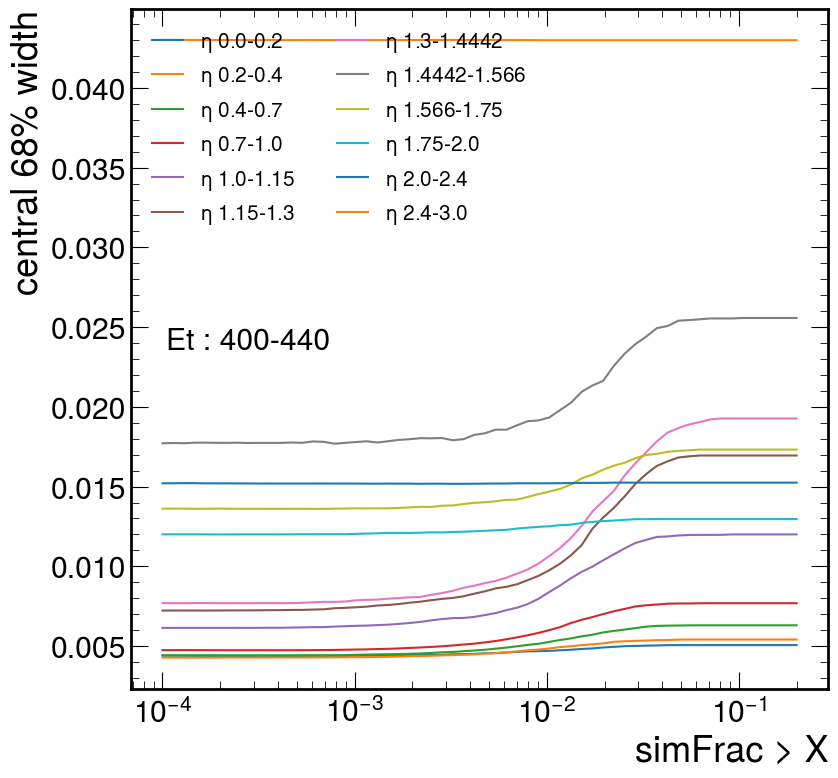

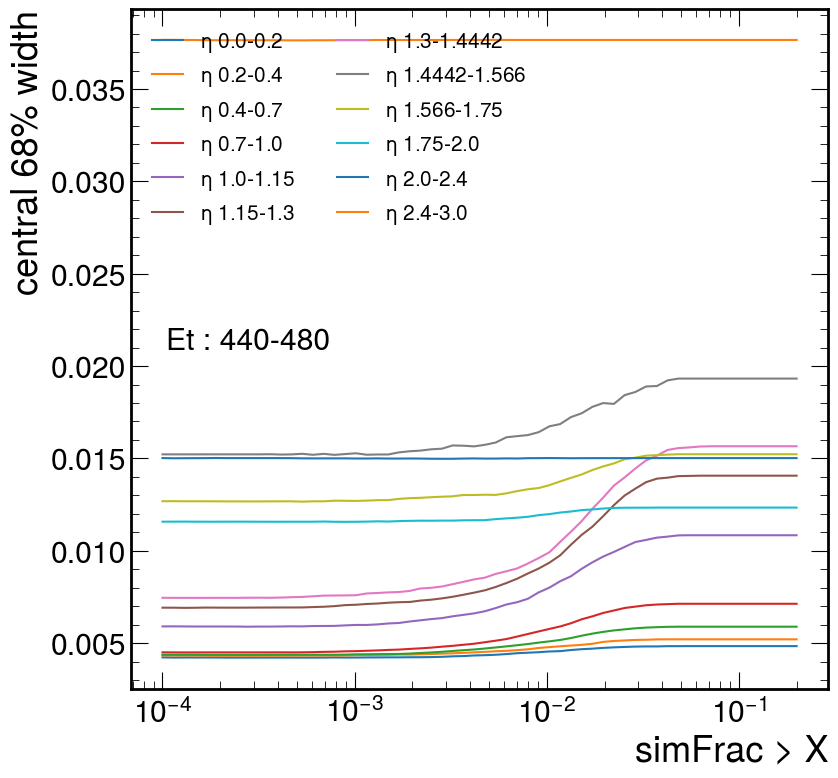

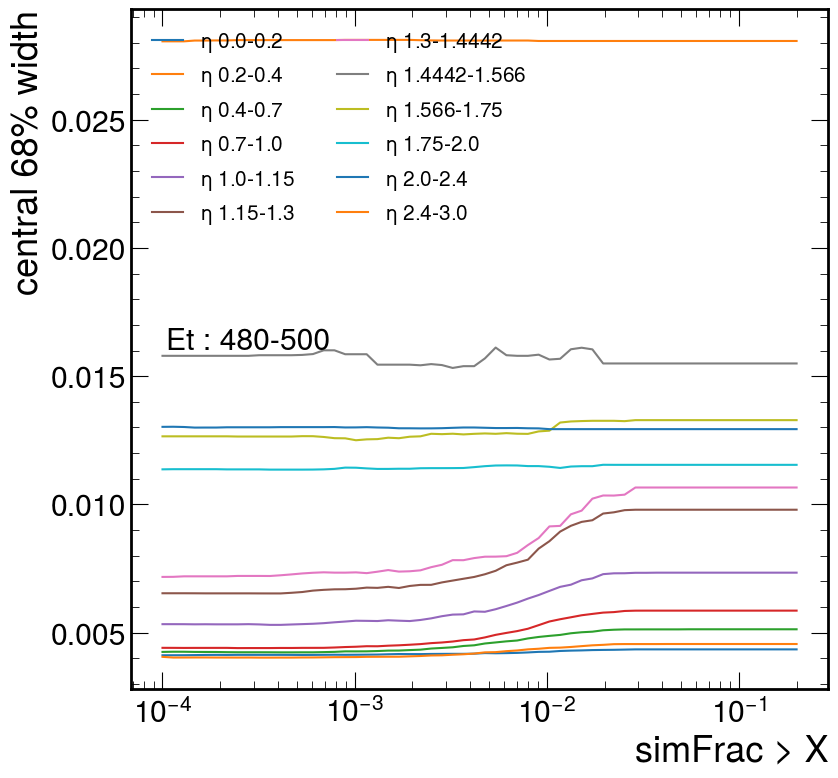

In [65]:
for iet in range(len(ets)-1):
    f, ax = plt.subplots(1,1, figsize=(9,9), dpi=100)

    for i in range(len(etas)-1): 
        a = res[(res.eta_bin == i) & (res.et_bin==iet)]
        ax.plot(a.thr, a.EoEtrue_68width, label='$\eta$ {}-{}'.format(etas[i], etas[i+1]))

    ax.text(0.05,0.5, "Et : {}-{}".format(ets[iet],ets[iet+1]),fontsize="small", transform=ax.transAxes)
    ax.legend(fontsize="xx-small", loc='upper left', ncol=2)
    ax.set_ylabel("central 68% width")
    ax.set_xlabel("simFrac > X")
    #     ax.set_xlim(0.01, 1000)
    ax.set_xscale("log")

    f.savefig(outputdir+'/Width_Et{}_{}.png'.format(ets[iet],ets[iet+1]))
    f.savefig(outputdir+'/Width_Et{}_{}.pdf'.format(ets[iet],ets[iet+1]))

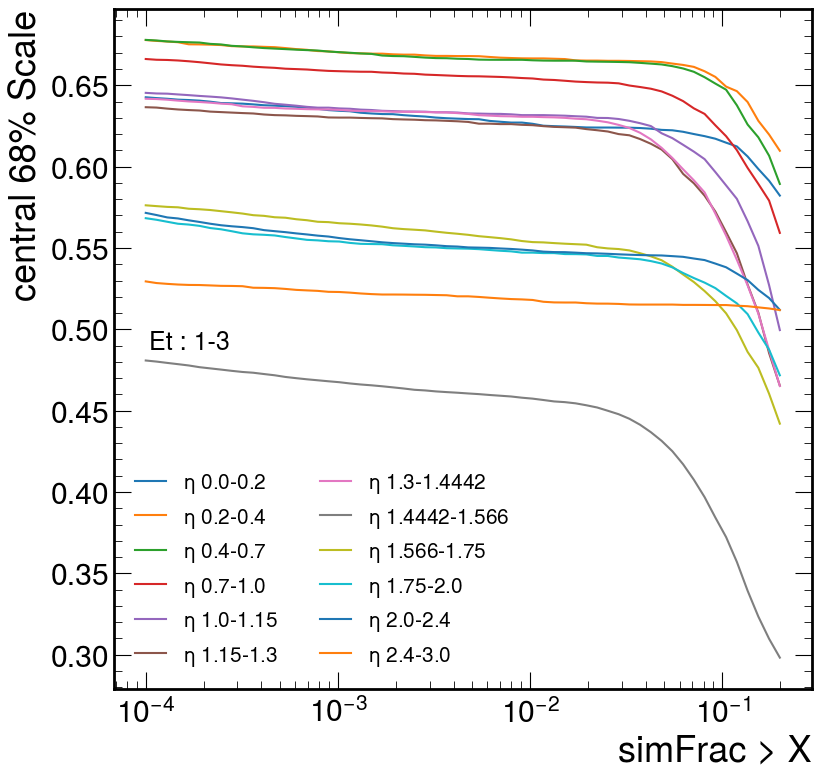

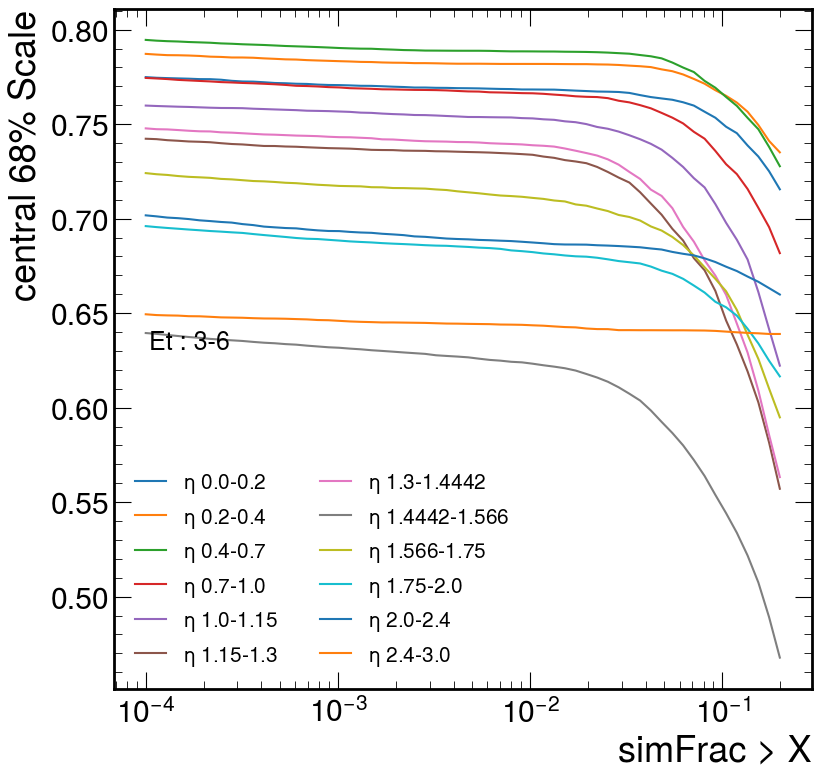

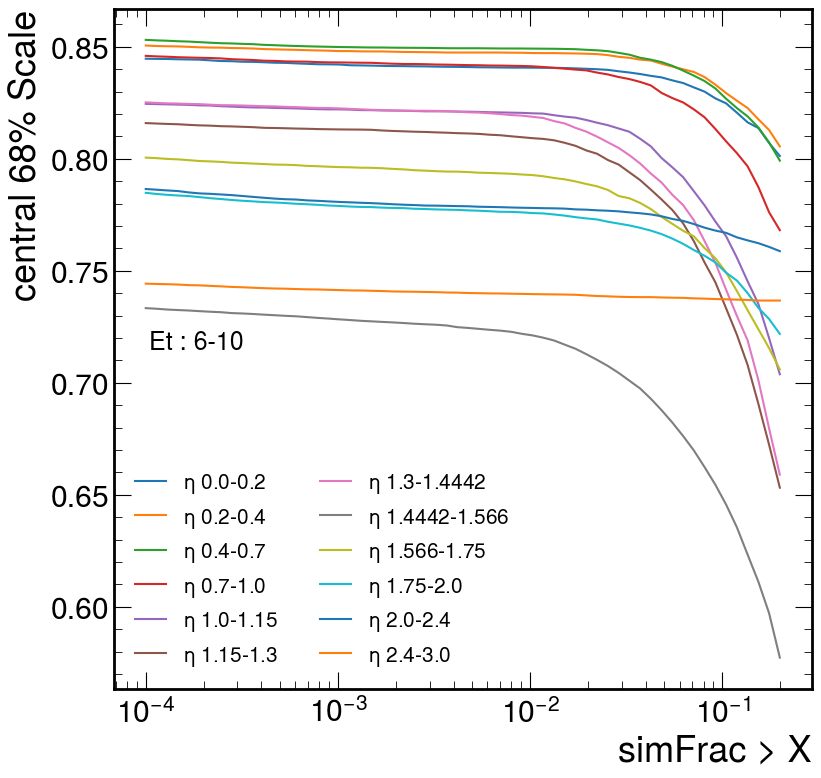

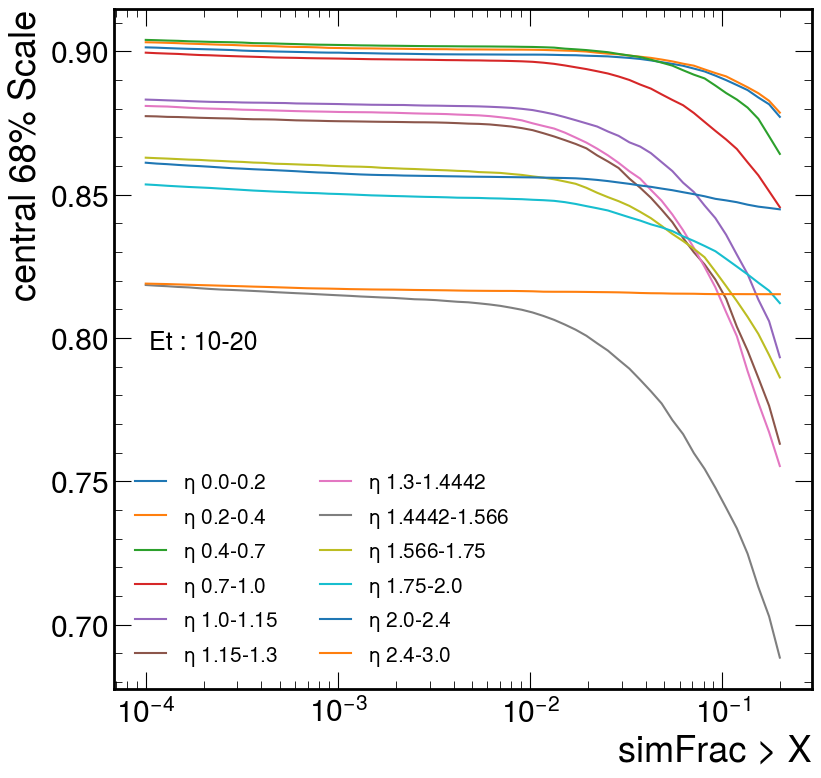

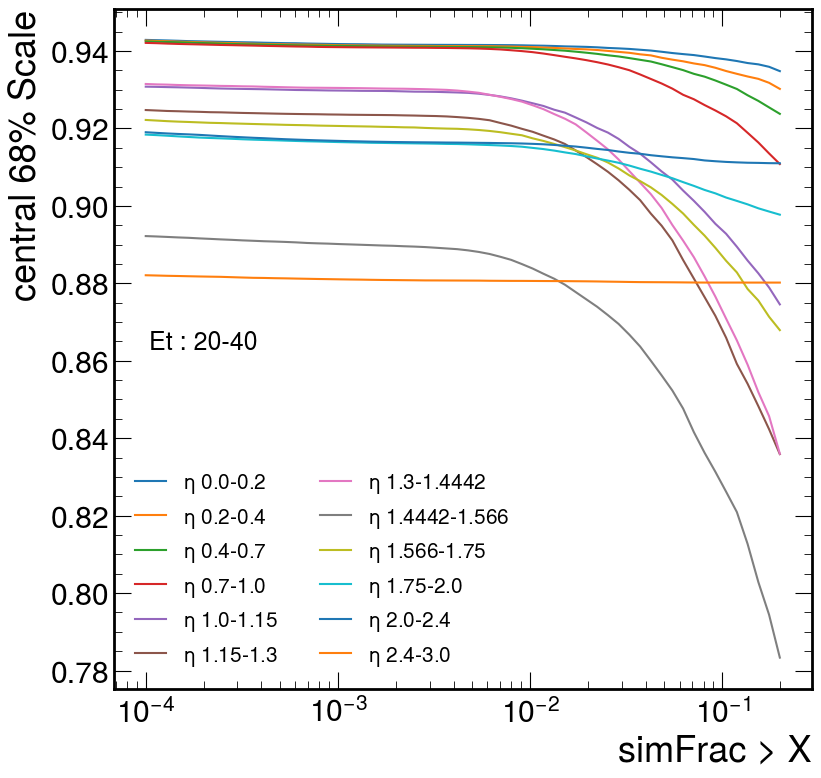

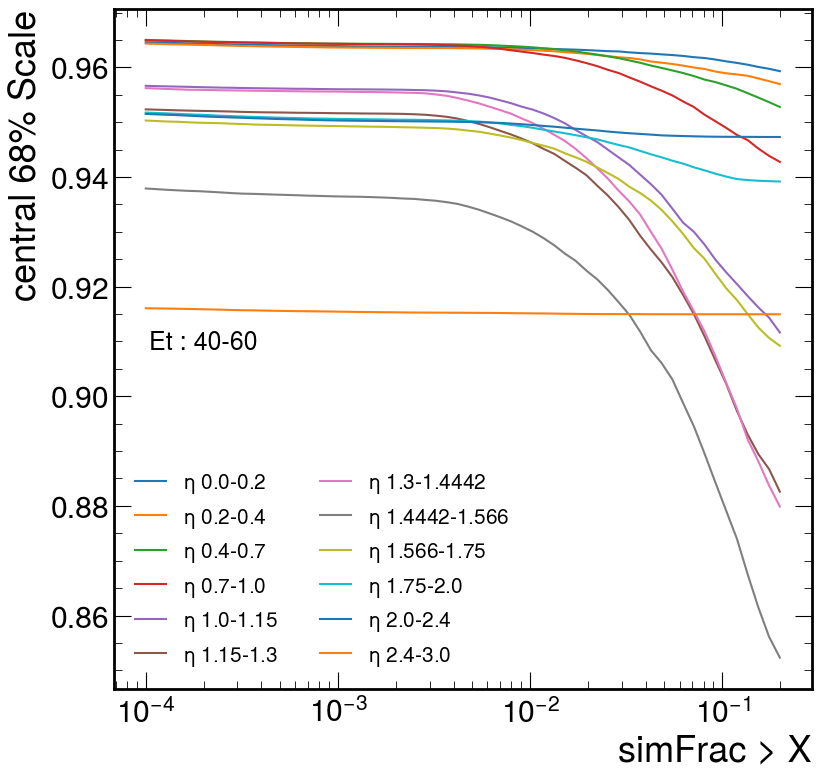

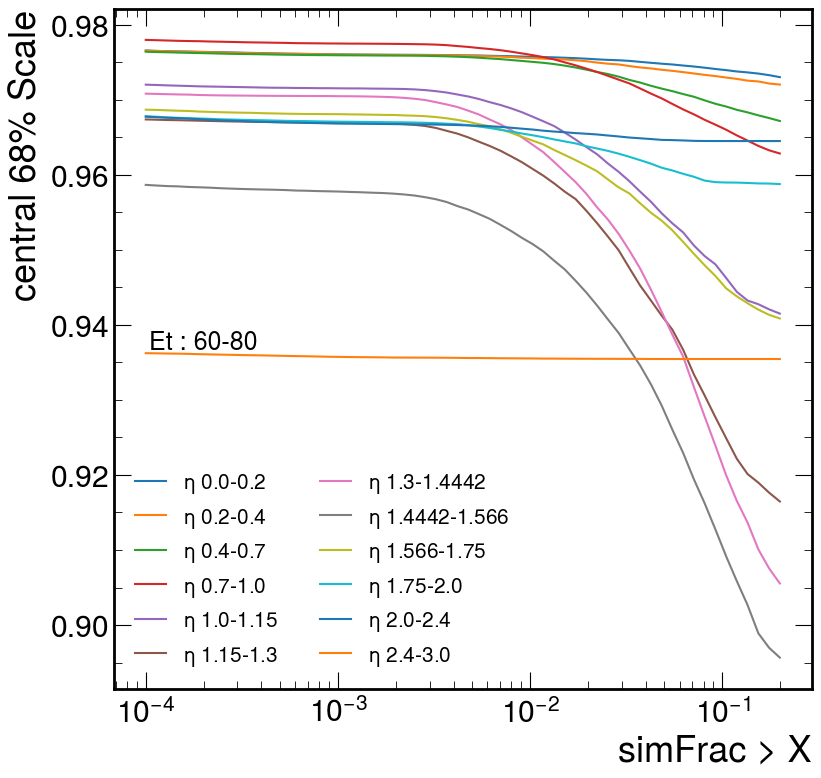

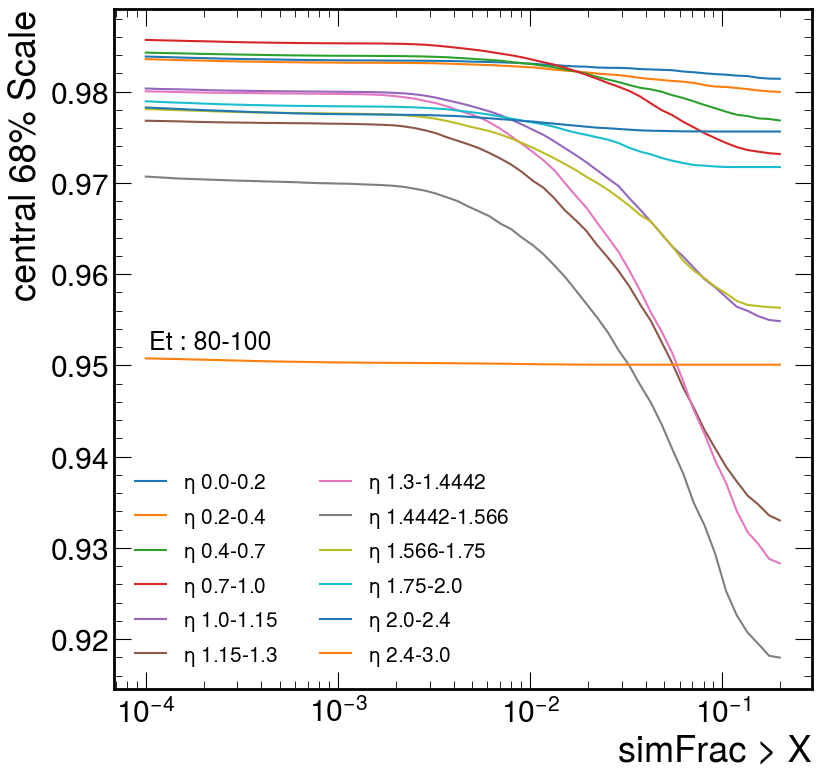

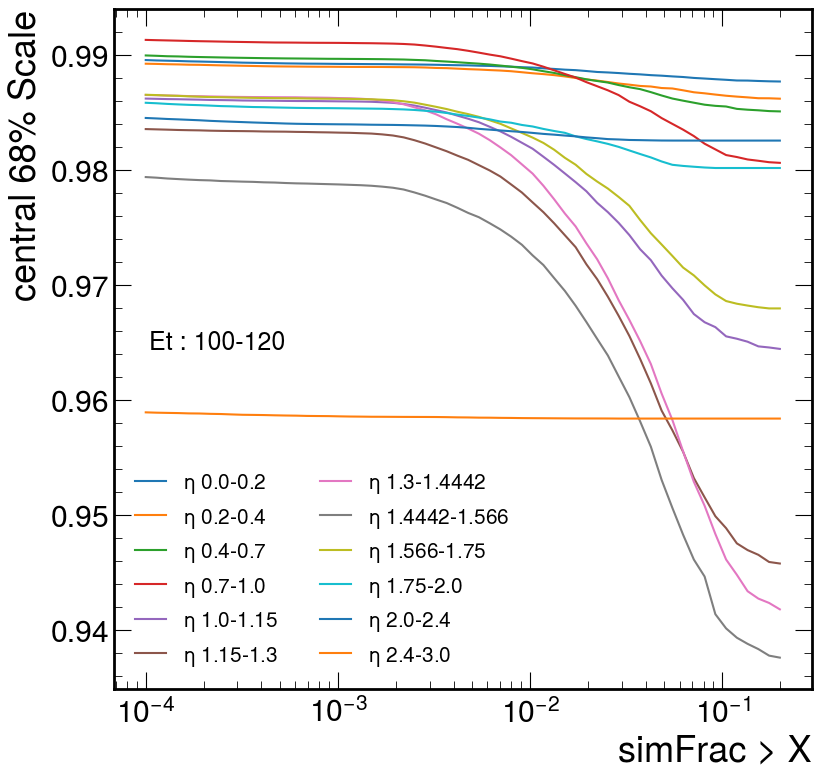

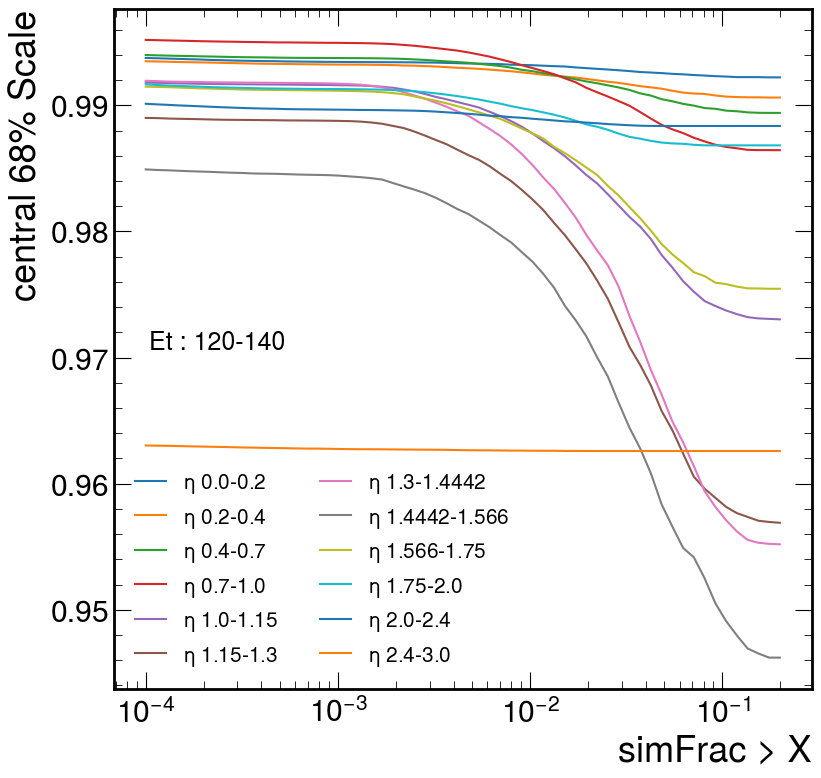

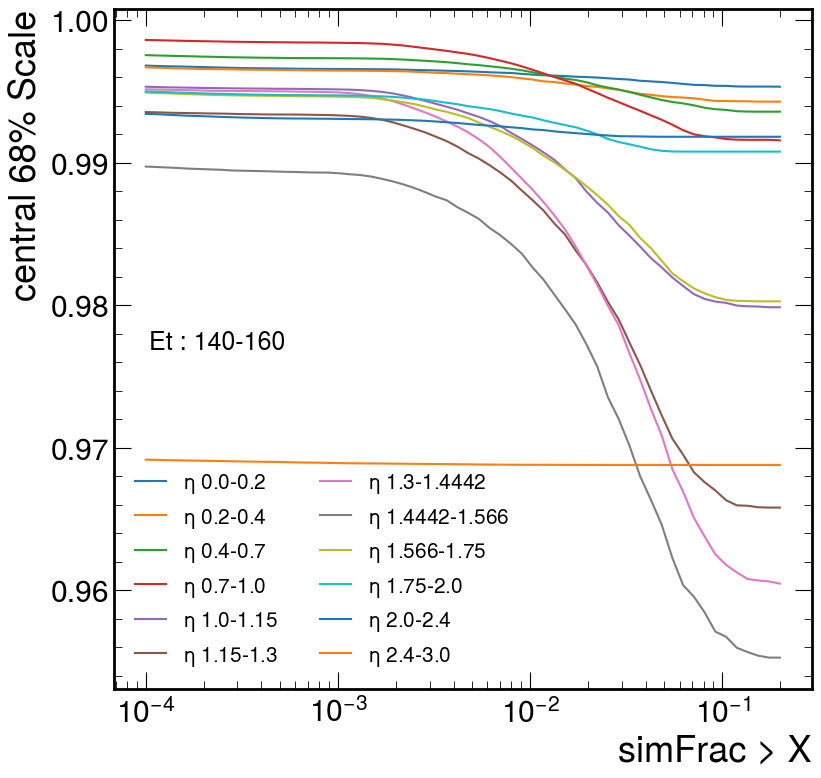

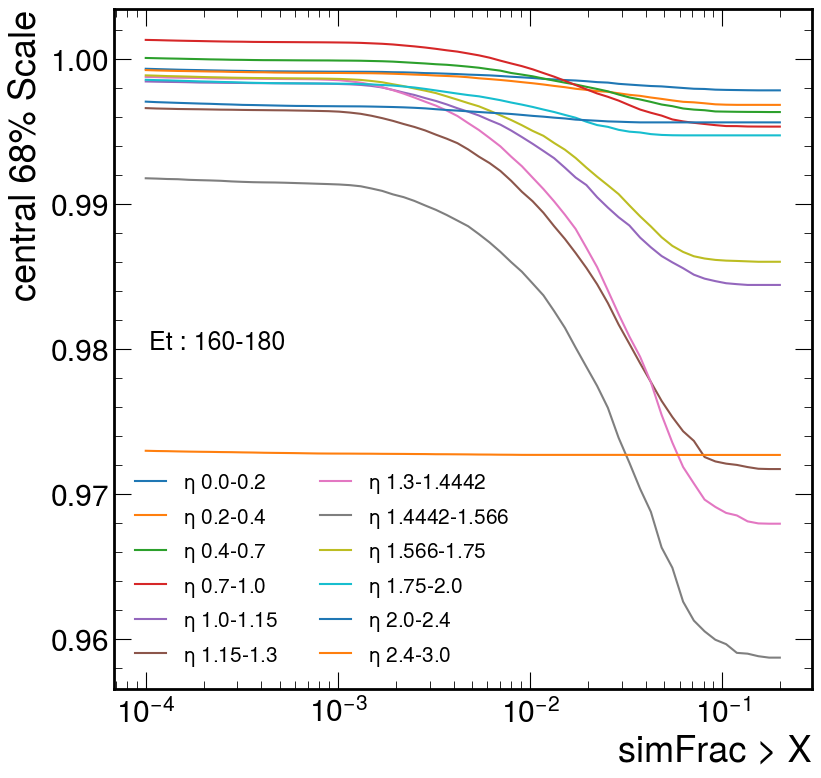

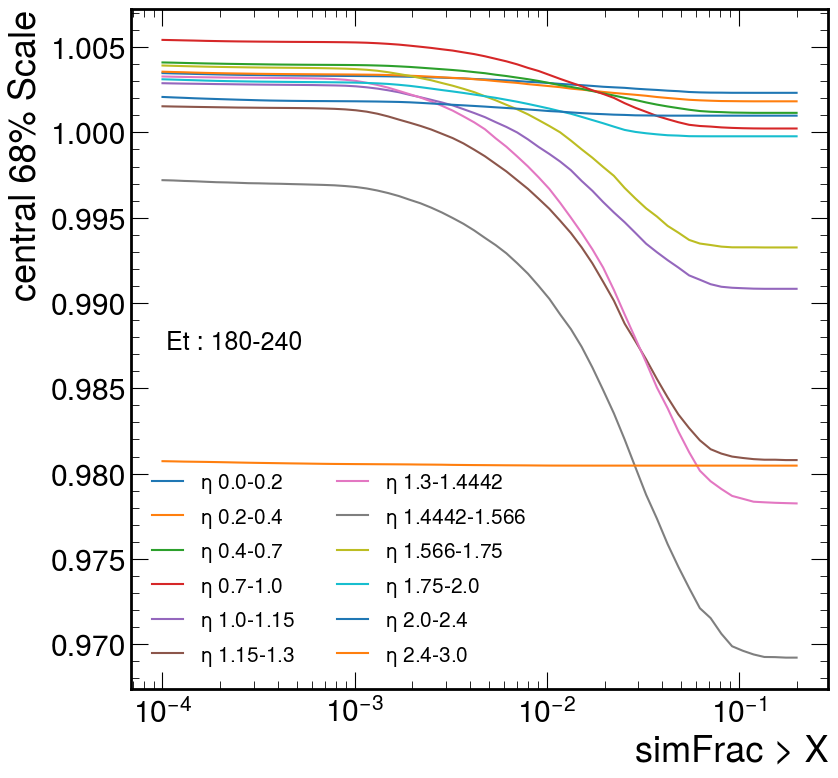

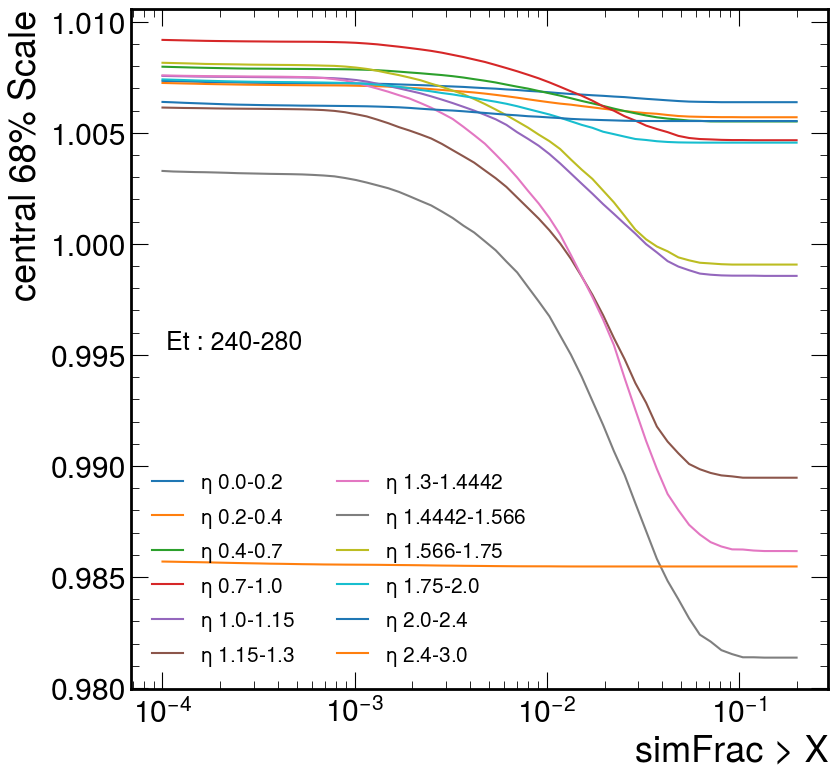

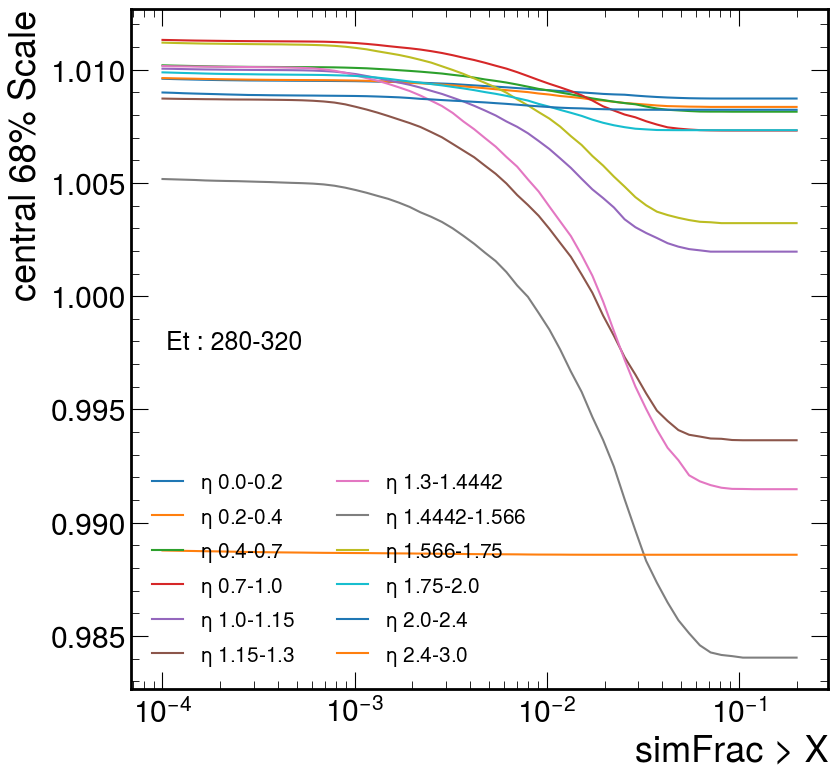

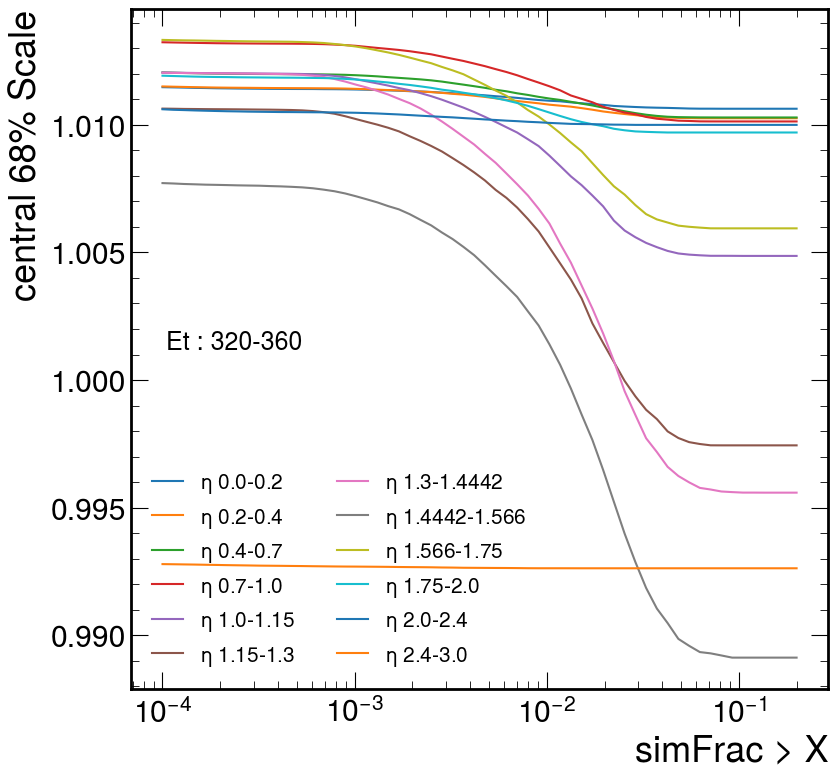

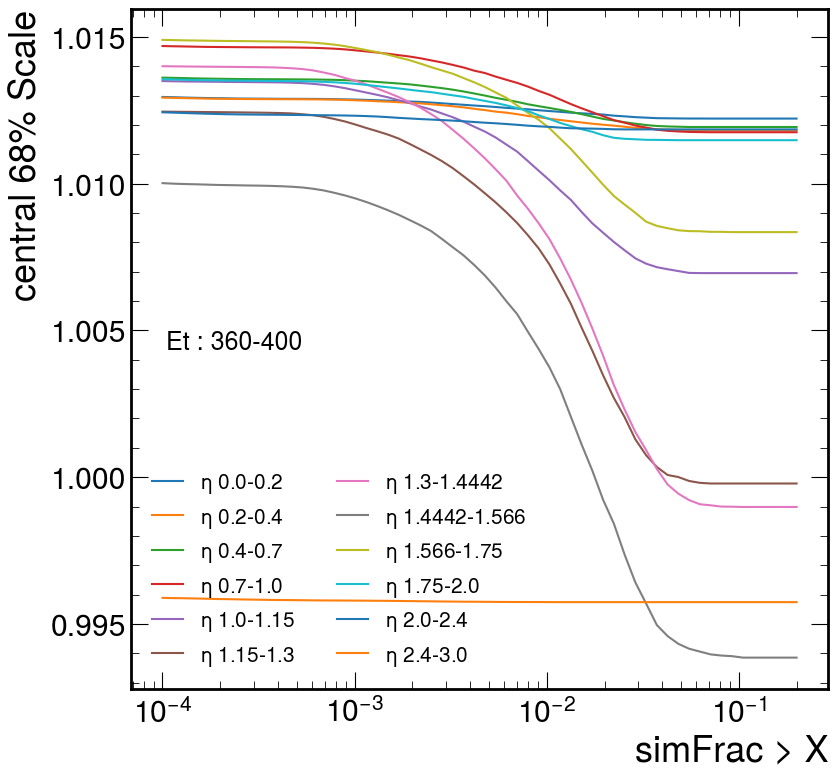

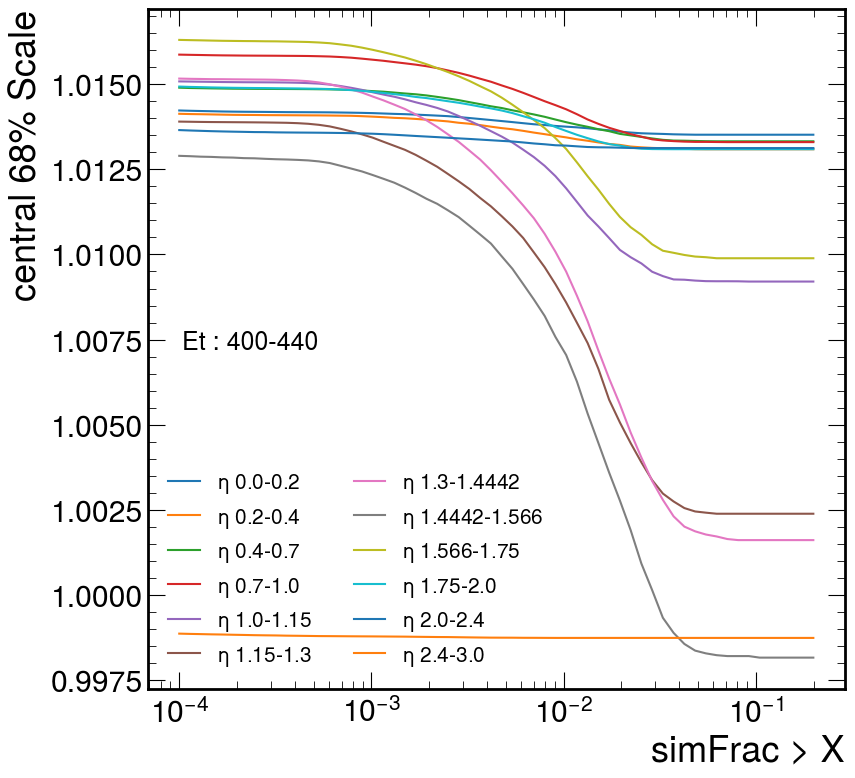

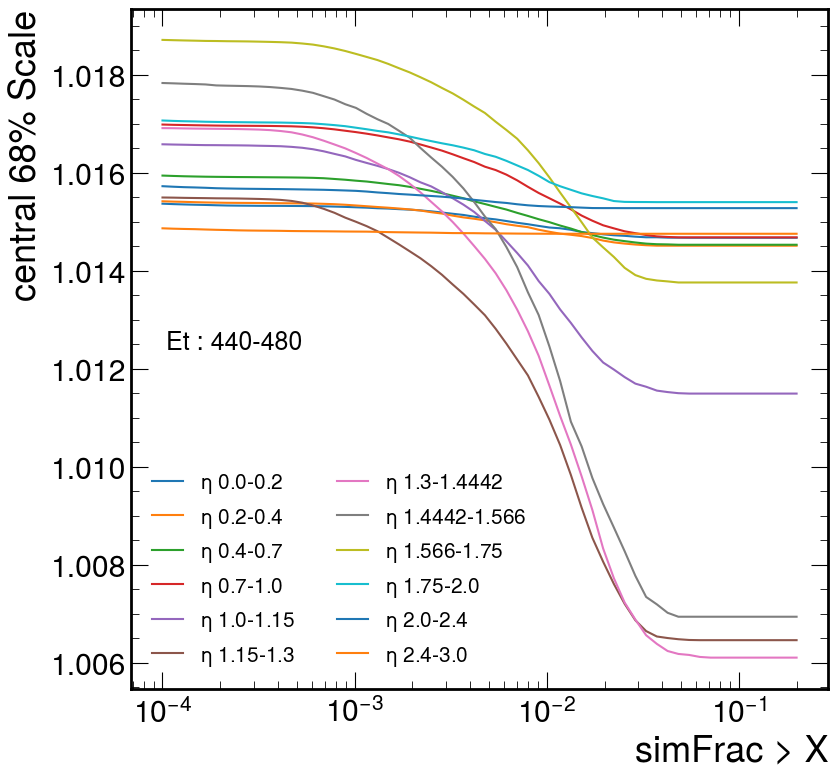

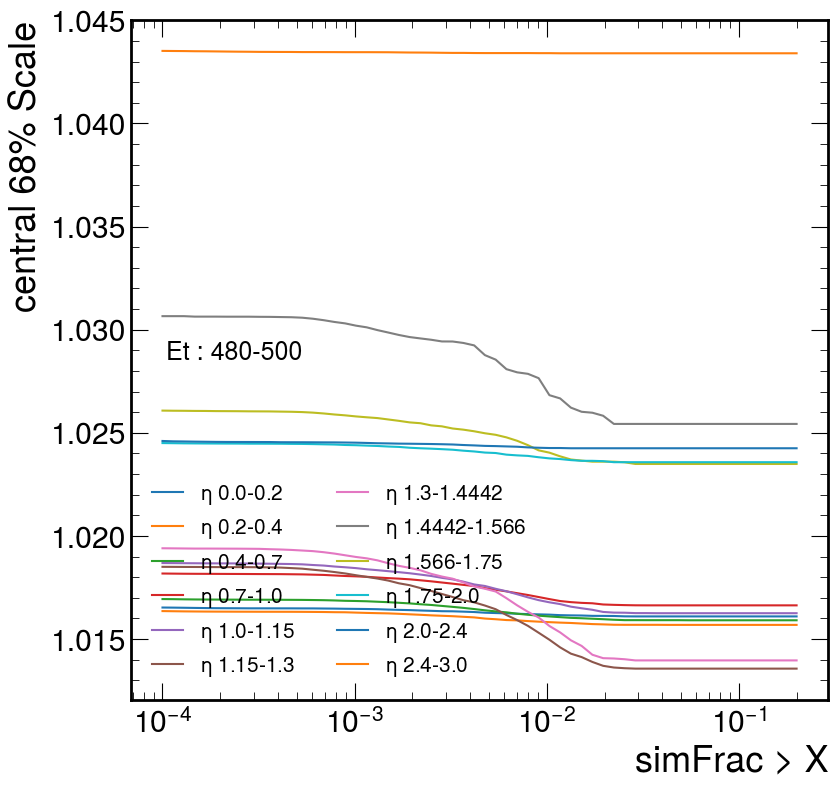

In [66]:
for iet in range(len(ets)-1):
    f, ax = plt.subplots(1,1, figsize=(9,9), dpi=100)

    for i in range(len(etas)-1): 
        a = res[(res.eta_bin == i) & (res.et_bin==iet)]
        ax.plot(a.thr, a.EoEtrue_68scale, label='$\eta$ {}-{}'.format(etas[i], etas[i+1]))

    ax.text(0.05,0.5, "Et : {}-{}".format(ets[iet],ets[iet+1]),fontsize="x-small", transform=ax.transAxes)
    ax.legend(fontsize="xx-small", loc='lower left', ncol=2)
    ax.set_ylabel("central 68% Scale")
    ax.set_xlabel("simFrac > X")
    #     ax.set_xlim(0.01, 1000)
    ax.set_xscale("log")

    f.savefig(outputdir+'/Scale_{}_{}.png'.format(ets[iet],ets[iet+1]))
    f.savefig(outputdir+'/Scale_{}_{}.pdf'.format(ets[iet],ets[iet+1]))

# Summary thresholds
Now we check which threshold corresponds to the best truth resolution in each eta/pt bin

In [5]:
etas = [0.0, 0.2, 0.4, 0.7, 1.0, 1.15, 1.3, 1.4442, 1.566, 1.75, 2.0,2.4,3.0]
ets = [ 1,3,6,10] + list(range(20, 200, 20)) + list(range(240, 500, 40)) + [500]

In [ ]:
def bin_analysis_summary(df):
    line = df.iloc[df["EoEtrue_68width"].argmin()]
    return pd.Series({
        "thr": line['thr'],
        "scale": line["EoEtrue_68width"],
        "width": line["EoEtrue_68width"],
        "rel_err" : line["rel_err"]
    })

a = res.groupby(['et_bin','eta_bin']).apply(bin_analysis_summary)
a.reset_index(level=0, inplace=True)
a.reset_index(level=0, inplace=True)

In [68]:
simfrac_thr = a
simfrac_thr.to_csv(outputdir+ "/best_resolution_simfrac_threshold.csv", sep=";", index=False)

In [6]:
#loading
simfrac_thr = pd.read_csv(outputdir+ "/best_resolution_simfrac_threshold.csv", sep=";")

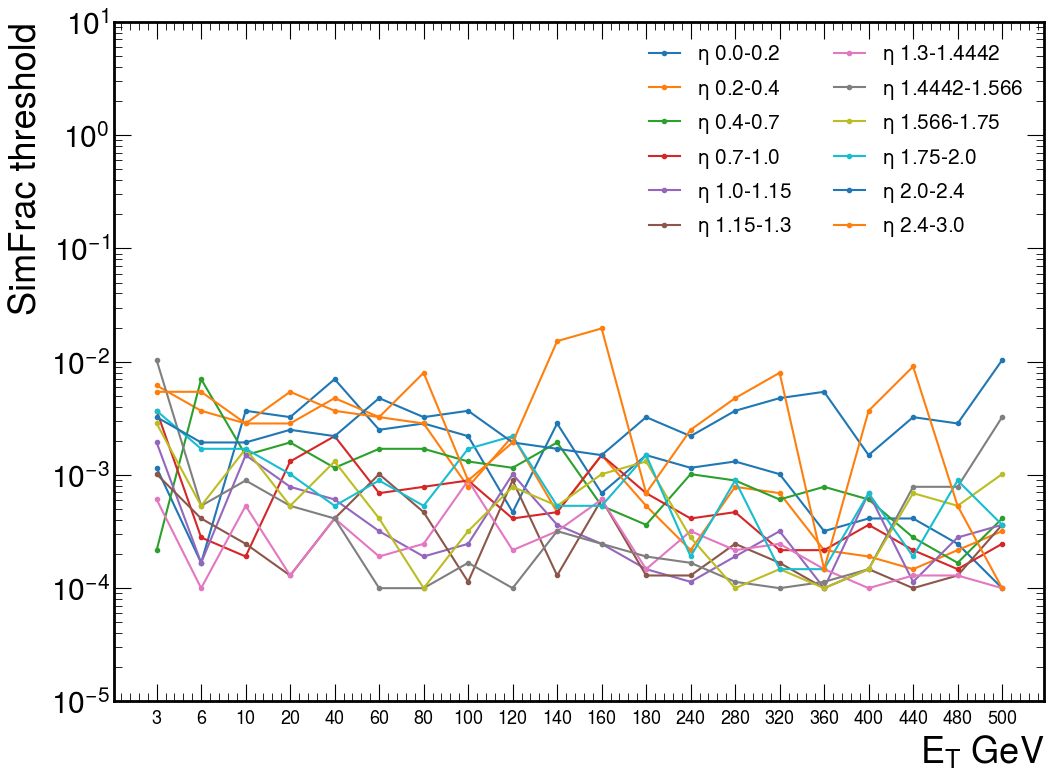

In [8]:
f, ax = plt.subplots(1,1, figsize=(12,9), dpi=100)

for i in range(len(etas)-1): 
    b = simfrac_thr[simfrac_thr.eta_bin == i]
    ax.plot(b.et_bin, b.thr, label='$\eta$ {}-{}'.format(etas[i], etas[i+1]), marker=".")

ax.legend(fontsize="xx-small", loc='upper right', ncol=2)
ax.set_ylabel("SimFrac threshold")
ax.set_xlabel("$E_T$ GeV")
ax.set_ylim(1e-5, 10)
ax.set_yscale("log")
ax.set_xticks(list(range(len(ets)-1)))
ax.set_xticklabels(["{}".format(et) for et in ets[1:]], fontsize=13)

f.savefig(outputdir+'/Scale_all_min.png')

/tmp/ipykernel_1166/1549900336.py:3: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.imshow(c.T, cmap="plasma", norm=LogNorm(vmin=1e-4, vmax=0.06), origin="lower", vmin=1e-4)


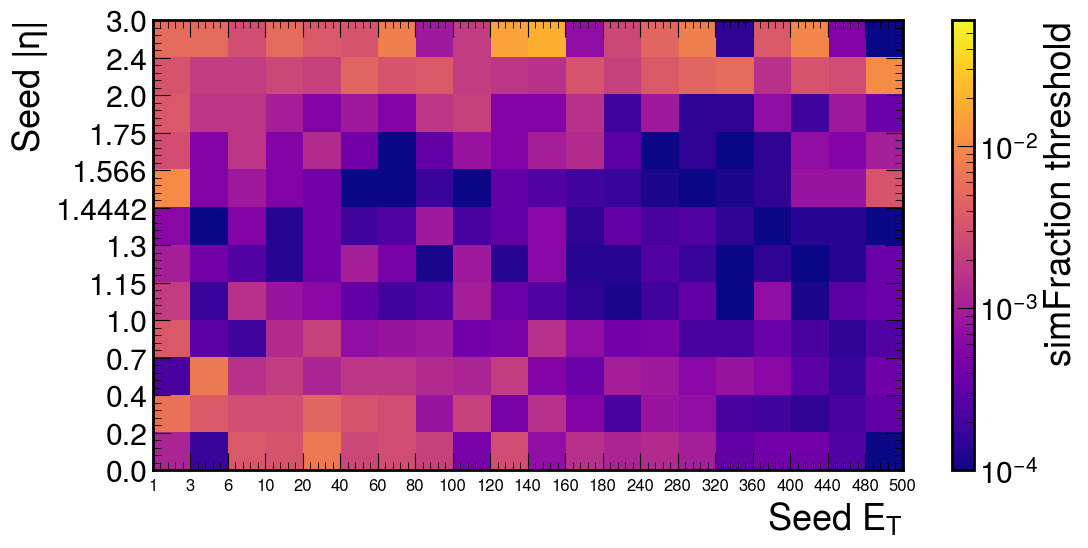

In [9]:
f = plt.figure(figsize=(12,6), dpi=100)
c = simfrac_thr.thr.values.reshape((len(ets)-1, len(etas)-1))
plt.imshow(c.T, cmap="plasma", norm=LogNorm(vmin=1e-4, vmax=0.06), origin="lower", vmin=1e-4)
plt.colorbar(label="simFraction threshold")
plt.xlabel("Seed $E_T$")
plt.ylabel("Seed $|\eta|$")
plt.xticks(np.arange(len(ets))-0.5, [ "{}".format(e) for e in ets], fontsize=12)
plt.yticks(np.arange(len(etas))-0.5, [ "{}".format(e) for e in etas])
f.tight_layout()
f.savefig(outputdir+ "/simfraction_map.png")
f.savefig(outputdir+ "/simfraction_map.pdf")

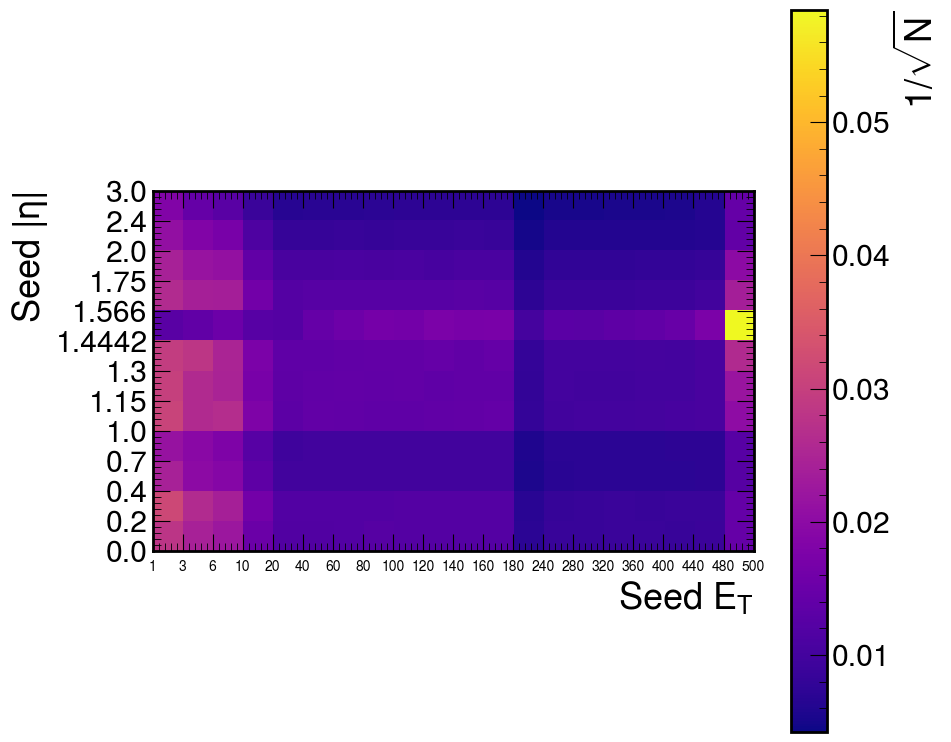

In [77]:
f = plt.figure(figsize=(10,8), dpi=100)
c = a.rel_err.values.reshape((len(ets)-1, len(etas)-1))
plt.imshow(c.T, cmap="plasma", origin="lower")
plt.colorbar(label="$1 / \sqrt{N}$")
plt.xlabel("Seed $E_T$")
plt.ylabel("Seed $|\eta|$")
plt.xticks(np.arange(len(ets))-0.5, [ "{}".format(e) for e in ets],fontsize=10)
plt.yticks(np.arange(len(etas))-0.5, [ "{}".format(e) for e in etas])
f.tight_layout()
f.savefig(outputdir+ "/simfraction_map_relerr.png")

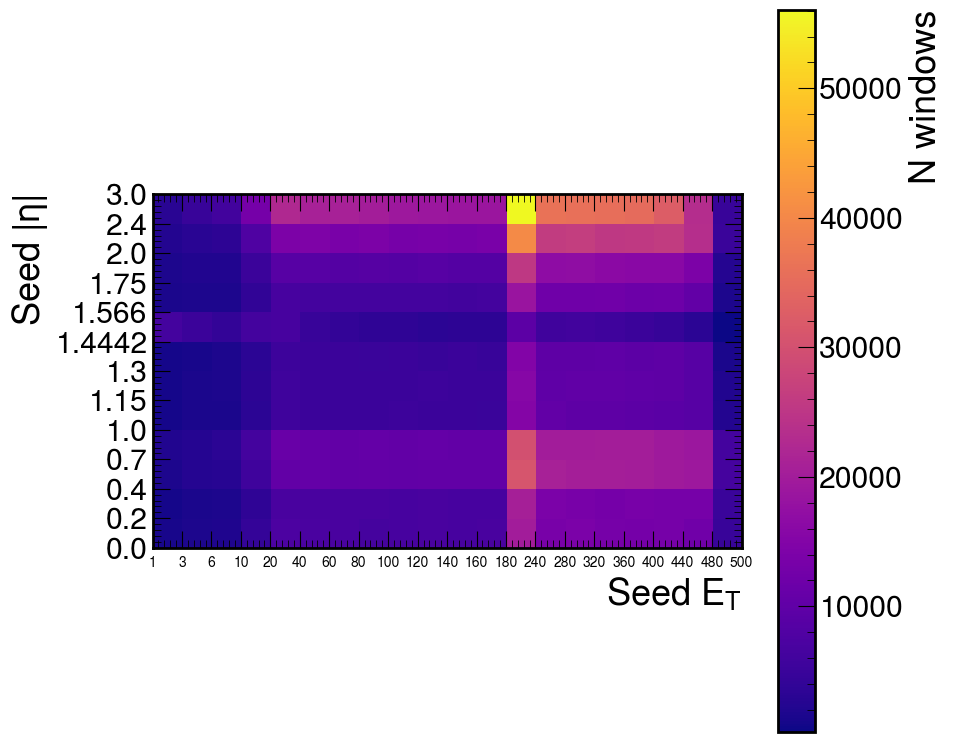

In [78]:
f = plt.figure(figsize=(10,8), dpi=100)
c = np.square((1/ a.rel_err).values).reshape((len(ets)-1, len(etas)-1))
plt.imshow(c.T, cmap="plasma", origin="lower")
plt.colorbar(label="N windows")
plt.xlabel("Seed $E_T$")
plt.ylabel("Seed $|\eta|$")
plt.xticks(np.arange(len(ets))-0.5, [ "{}".format(e) for e in ets], fontsize=10)
plt.yticks(np.arange(len(etas))-0.5, [ "{}".format(e) for e in etas])
f.tight_layout()
f.savefig(outputdir+ "/simfraction_map_Nwindows.png")

# Export to correctionlib

In [10]:
 # Exporting it to correctionlib
import correctionlib, rich
import correctionlib.convert
import hist

h_weight = hist.Hist(
            hist.axis.Variable(ets, name="seed_et"),
            hist.axis.Variable(etas, name="seed_eta"),
            storage="double",
            data=simfrac_thr.thr.values.reshape((len(ets)-1, len(etas)-1)))


# without a name, the resulting object will fail validation
h_weight.name = "simfraction_thres"
h_weight.label = "min_simfraction"
clibcorr = correctionlib.convert.from_histogram(h_weight)
clibcorr.description = "Simfraction threshold for electrons 235fb noise - 235fb PFRechits thresholds"
clibcorr.data.flow="clamp"

cset = correctionlib.schemav2.CorrectionSet(
    schema_version=2,
    description=clibcorr.description,
    corrections=[clibcorr],
)
rich.print(cset)

flavour="electron"
version="235_235"
with open(f"{outputdir}/simfraction_{flavour}_{version}.json", "w") as fout:
    fout.write(cset.json(exclude_unset=True))


CorrectionSet (schema v2)
Simfraction threshold for electrons 235fb noise - 235fb PFRechits thresholds
📂
└── 📈 simfraction_thres (v0)
    Simfraction threshold for electrons 235fb noise - 235fb PFRechits thresholds
    Node counts: MultiBinning: 1
    ╭──────────── ▶ input ─────────────╮ ╭─────────── ▶ input ────────────╮
    │ seed_et (real)                   │ │ seed_eta (real)                │
    │ seed_et                          │ │ seed_eta                       │
    │ Range: [1.0, 500.0), overflow ok │ │ Range: [0.0, 3.0), overflow ok │
    ╰──────────────────────────────────╯ ╰────────────────────────────────╯
    ╭─────── ◀ output ───────╮
    │ min_simfraction (real) │
    │ No description         │
    ╰────────────────────────╯

In [11]:
cset = correctionlib.CorrectionSet.from_file(f"{outputdir}/simfraction_electron_235_235.json")
corr_et = cset["simfraction_thres"]

# Save histogram

Welcome to JupyROOT 6.26/08


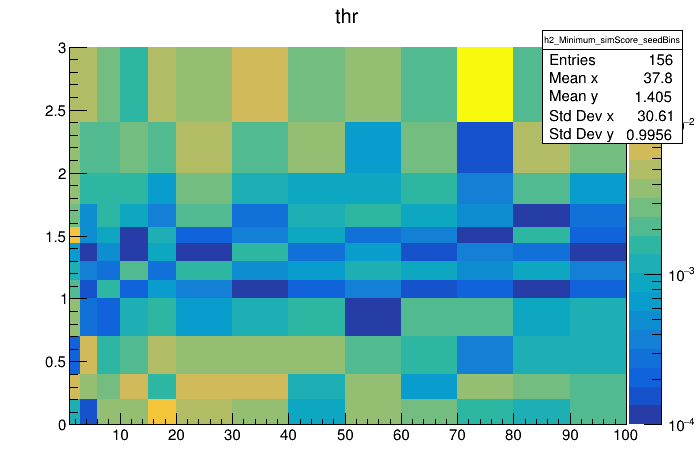

In [43]:
import ROOT as R
from array import array

h2 = R.TH2F("h2_Minimum_simScore_seedBins", "thr", len(ets)-1, array("d", ets), len(etas)-1, array("d", etas))

for _, row in a.iterrows():
    h2.SetBinContent(h2.FindBin(ets[int(row.et_bin)], etas[int(row.eta_bin)]), row.thr)
    
c = R.TCanvas()
h2.Draw("COLZ")
c.SetLogz()
c.Draw()

out = R.TFile(outputdir+"/simScore.root","RECREATE")
h2.Write()
out.Close()

We loop on all the eta and et bins and apply the best threshold. Then we take the maximum dphi and deta from the seed to study the dimension of the window

# Window dimension after simFraction selection 
## Dimension by eta and Et

In [92]:
# Requiring a minimum of 1% of simFraction for the seeds for quality
dfb = dfa[(dfa.seed_simfrac_sig > 0.01)]  # Do now require any geometrical window limit  & (dfa.in_window)
dfb["et_bin"] = pd.cut(dfb["seed_et"], ets, labels=list(range(len(ets)-1)))
dfb["eta_bin"] = pd.cut(dfb["seed_eta"].abs(), etas, labels=list(range(len(etas)-1)))

/tmp/ipykernel_847/1387350978.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfb["et_bin"] = pd.cut(dfb["seed_et"], ets, labels=list(range(len(ets)-1)))
/tmp/ipykernel_847/1387350978.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfb["eta_bin"] = pd.cut(dfb["seed_eta"].abs(), etas, labels=list(range(len(etas)-1)))


In [93]:
results = []
for (iet, ieta), g in  dfb.groupby(["et_bin", "eta_bin"]):
    #print(f"Working on Et:{iet}, Eta:{ieta}")
    thr = simfrac_thr[(simfrac_thr.eta_bin == ieta)&(simfrac_thr.et_bin == iet)].thr
    A =  g[(g.simfrac_sig >  thr.values[0]) | (g.is_seed==1) ].groupby("window_index", sort=False).agg(
                        {
                         "dphi_seed": 'max' ,
                         "deta_seed": "max", 
                    })
    A["ieta"] = ieta
    A["iet"] = iet
    results.append(A)
    
WS = pd.concat(results)

Text(1, 0, 'Max $\\Delta\\phi(cl-seed)$')

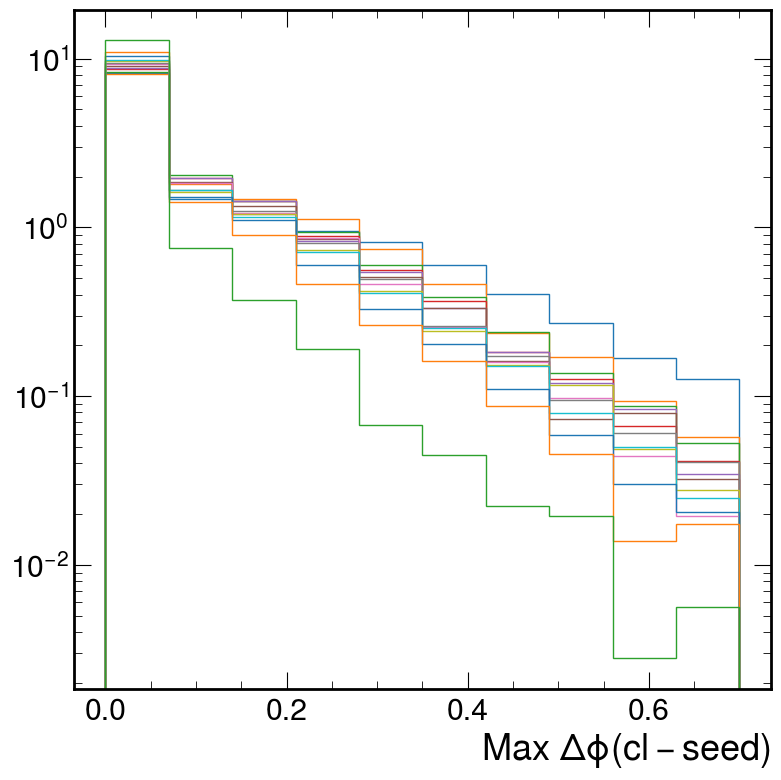

In [95]:
nEt = len(ets)-1
nEta = len(etas)-1
f, ax  = plt.subplots(1,1, figsize=(9,9), dpi=100)
iEta = 5
for iEt in range(nEt):
    ax.hist(WS[(WS.iet==iEt)&(WS.ieta==iEta)].dphi_seed, 
             label=f"$\eta$=[{etas[iEta]},{etas[iEta+1]}], $E_T$=[{ets[iEt]},{ets[iEt+1]}]",
             range=(0, 0.7), bins=10, histtype="step", density=True)
ax.set_yscale("log")
ax.set_xlabel("Max $\Delta\phi(cl-seed)$")
#ax.legend()

Text(1, 0, 'Max $\\Delta\\eta(cl-seed)$')

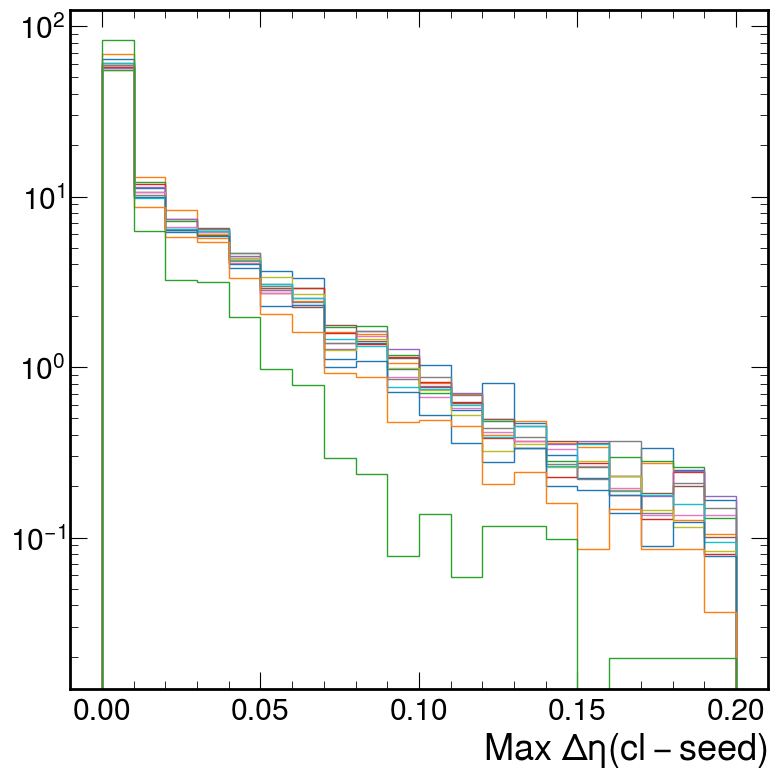

In [96]:
f, ax  = plt.subplots(1,1, figsize=(9,9), dpi=100)
iEta = 5
for iEt in range(nEt):
    ax.hist(WS[(WS.iet==iEt)&(WS.ieta==iEta)].deta_seed, 
             label=f"$\eta$=[{etas[iEta]},{etas[iEta+1]}], $E_T$=[{ets[iEt]},{ets[iEt+1]}]",
             range=(0, 0.2), bins=20, histtype="step", density=True)
ax.set_yscale("log")
ax.set_xlabel("Max $\Delta\eta(cl-seed)$")
#ax.legend()

## Only by seed Eta

In [98]:
results = []
for ieta, g in  dfb.groupby("eta_bin"):
    #print(f"Working on Et:{iet}, Eta:{ieta}")
    thr = simfrac_thr[(simfrac_thr.eta_bin == ieta)].thr
    A =  g[(g.simfrac_sig >  thr.values[0]) | (g.is_seed==1) ].groupby("window_index", sort=False).agg(
                        {
                         "dphi_seed": [np.min, np.max],
                         "deta_seed":  [np.min, np.max]
                    })
    A["ieta"] = ieta
    results.append(A)
    
WS_etaonly = pd.concat(results)

In [99]:
WS_etaonly.dphi_seed.amin

window_index
afhojuvx    0.0
wdmeslyv    0.0
glgkbwxr    0.0
cmndinii    0.0
uguqfsjc    0.0
           ... 
rjvtbuak    0.0
mufeffek    0.0
swjpcpxe    0.0
izewslff    0.0
jqzyvjvq    0.0
Name: amin, Length: 1947566, dtype: float64

In [100]:
maxq = 0.995
maxWS_eo = WS_etaonly.groupby('ieta').apply(lambda df: pd.Series(
    {"dphi_min": df.dphi_seed.amin.quantile(1-maxq),
     "dphi_max": df.dphi_seed.amax.quantile(maxq),
     "deta_min": df.deta_seed.amin.quantile(1-maxq),
     "deta_max": df.deta_seed.amax.quantile(maxq)}))

maxWS_eo.reset_index(level=0, inplace=True)
maxWS_eo.reset_index(level=0, inplace=True)

Text(0, 1, '$\\Delta\\phi$')

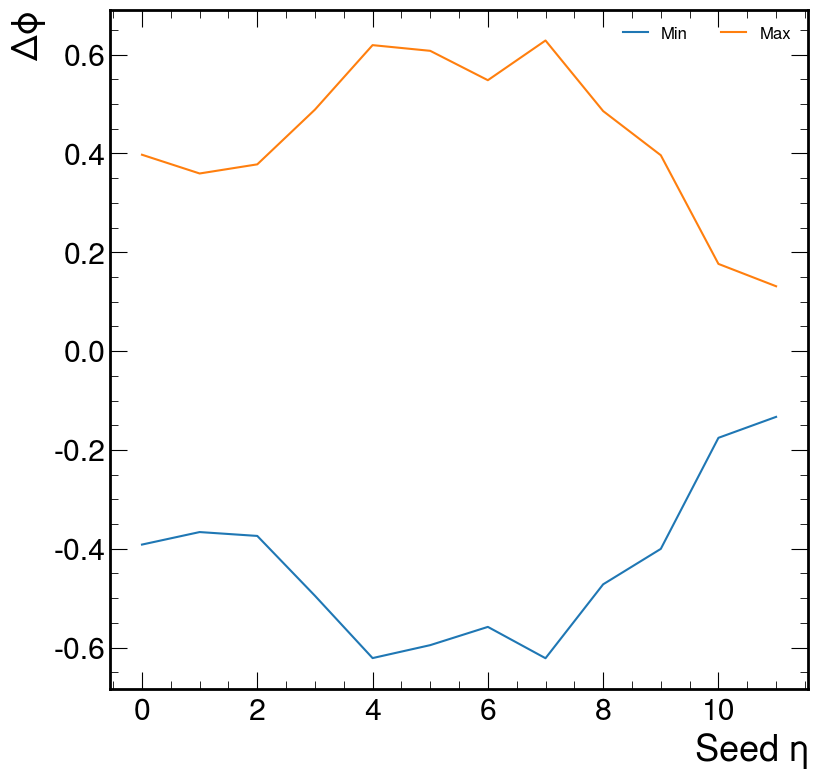

In [101]:
f, ax  = plt.subplots(1,1, figsize=(9,9), dpi=100)
ax.plot(maxWS_eo.ieta, maxWS_eo.dphi_min, label="Min")
ax.plot(maxWS_eo.ieta, maxWS_eo.dphi_max, label="Max")

ax.legend(ncol=3, fontsize="12")
#ax.set_xticklabels(etas)
ax.set_xlabel("Seed $\eta$")
ax.set_ylabel("$\Delta\phi$")

Text(0, 1, '$\\Delta\\eta$')

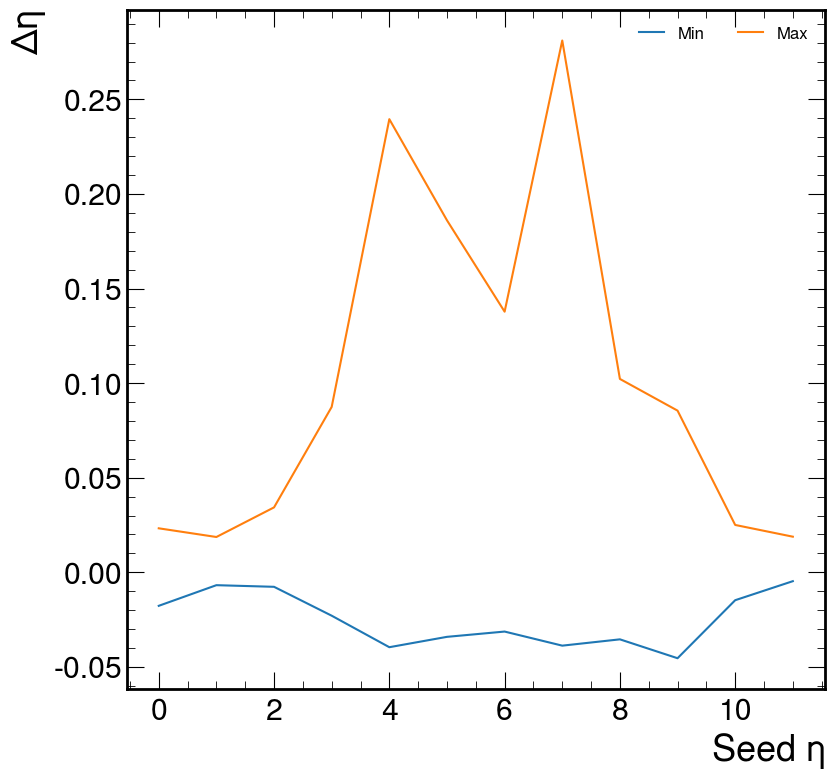

In [102]:
f, ax  = plt.subplots(1,1, figsize=(9,9), dpi=100)

ax.plot(maxWS_eo.ieta, maxWS_eo.deta_min, label="Min")
ax.plot(maxWS_eo.ieta, maxWS_eo.deta_max, label="Max")

ax.legend(ncol=3, fontsize="12")
#ax.set_xticklabels(etas)
ax.set_xlabel("Seed $\eta$")
ax.set_ylabel("$\Delta\eta$")